In [1]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd # Data structures
import numpy as np # Matrix algebra
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters # Plotting
register_matplotlib_converters() # Plotting
import seaborn as sns # Plotting
import gc # Garbage collection

In [2]:
### VERSIONS CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [3]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### UN Comtrade aggregated data container with Acadian materials:
str_path_acadian = 'Data_Files/Source_Files/unc_res_acadian.h5'
str_key_acadian = 'acadian'
### UN Comtrade aggregated data container with total countries trade:
str_path_global = 'Data_Files/Source_Files/unc_res_all_world.h5'
str_key_unc ='unc_res'
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2021-12-31'
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Regions:
list_region = ['DM', 'EM', 'FM']

In [4]:
### DEFINING EXTRACTION ISON UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                    na_values = list_na_excel_values, keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [5]:
### RUN EVERY TIME: ISON DATA EXTRACTION STEPS

### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON countrys status on 2021-12-31:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
ser_ison_status.index.name = 'Reporter'

In [6]:
### DEFINING DATA EXTRACTION PROCEDURE

def get_comtrade_data(str_comtrade_id = None, # Use UN Comtrade HS 1992 Commodity ID i.e '2711'
                      str_flow = None, # Use 'Export' or 'Import'
                      str_start_year = None, # Use 'YYYY' format i.e. '1994'
                      str_end_year = None, # Use 'YYYY' format i.e. '2015'
                      str_reporter = None, # Use ISO short codes for countries i.e. 'US'
                      str_partner = None, # Use 'World' for World and ISO short codes for countries i.e. 'US'
                      str_name = None, # Use commodity code from concordance spreadsheet i.e. 'Cattle'
                      str_flag = None # Use 0 for those commodities that don't have AG6 alternative, 1 - for AG2/AG4 alternative, 2 - for AG6 alternative
                     ):
    ### Request parameters preparation:
    dict_conditions = {}
    if (str_comtrade_id is not None):        
        dict_conditions['Commodity_ID'] = 'str_comtrade_id'
    else:
        dict_conditions['Commodity_ID'] = None     
    if (str_flow is not None):        
        dict_conditions['Flow'] = 'str_flow'
    else:
        dict_conditions['Flow'] = None           
    if (str_start_year is not None):
        str_start_date = (pd.to_datetime(str_start_year) + pd.offsets.BYearEnd()).strftime('%Y-%m-%d')
    else:
        str_start_date = '1981-12-31'
    if (str_end_year is not None):
        str_end_date = (pd.to_datetime(str_end_year) + pd.offsets.BYearEnd()).strftime('%Y-%m-%d')
    else:
        str_end_date = '2020-12-31'
    if (str_reporter is not None):        
        dict_conditions['Reporter'] = 'str_reporter'
    else:
        dict_conditions['Reporter'] = None           
    if (str_partner is not None):        
        dict_conditions['Partner'] = 'str_partner'
    else:
        dict_conditions['Partner'] = None           
    if (str_name is not None):        
        dict_conditions['Commodity_Name'] = 'str_name'
    else:
        dict_conditions['Commodity_Name'] = None           
    if (str_flag is not None):        
        dict_conditions['Flag'] = 'str_flag'
    else:
        dict_conditions['Flag'] = None           
        
    if ((str_start_date == '1981-12-31') & (str_end_date == '2020-12-31')):
        list_filter = []
    else:
        list_filter = ['(Date >= str_start_date) & (Date <= str_end_date)']
    ### Request constructing:
    for iter_level in dict_conditions:
        if (dict_conditions[iter_level] is not None):
            list_filter.append('(' + iter_level + ' in ' + dict_conditions[iter_level] + ')')
    print(' & '.join(list_filter))
    ### Request implementing:
    ser_res = pd.read_hdf(path_or_buf = str_path_acadian, key = str_key_acadian, where = ' & '.join(list_filter)).sort_index()
    return ser_res        

In [7]:
### STATS: IMPORT COVERAGE: DATA LOADING

gc.collect()
### Bilateral data only:
df_comm_full = get_comtrade_data(str_flow = 'Import', str_flag = [0, 1]).reset_index()
df_comm_full = df_comm_full[df_comm_full['Partner'] != 'World']
### Total trading:
df_comm_world = get_comtrade_data(str_flow = 'Import', str_flag = [0, 1], str_partner = 'World').reset_index()
ser_ison_status.index.name = 'Reporter'

(Flow in str_flow) & (Flag in str_flag)
(Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


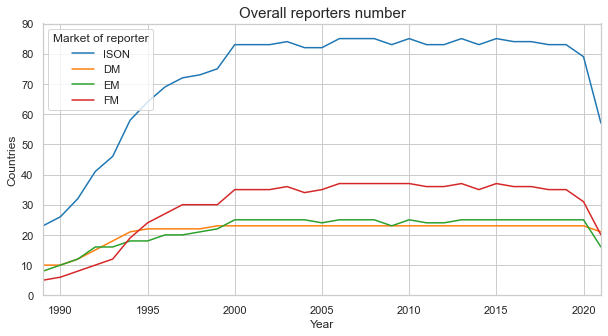

In [8]:
### STATS: IMPORT COVERAGE: REPORTERS NUMBER

### Adding regions of reporters and partners:
df_coverage_full = df_comm_full.join(ser_ison_status, on = 'Reporter', rsuffix = '_Reporter').join(ser_ison_status, on = 'Partner', rsuffix = '_Partner')
df_coverage_full.rename({'Market': 'Reporter_Market', 'Market_Partner': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Number'
dict_reporters['ISON']  = ser_iter_reporters
### Region's reporters number:
for iter_region in list_region:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Number'
    dict_reporters[iter_region]  = ser_iter_reporters
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).reset_index()
df_to_plot = df_reporters.rename({'level_0': 'Market of reporter'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of reporter')
ax_reporters.set_title('Overall reporters number', fontsize = 15)
ax_reporters.set(xlim = (1989, 2021), ylim = (0, 90), ylabel = 'Countries')
plt.show()

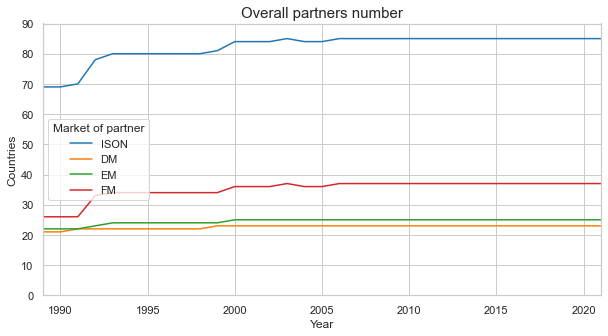

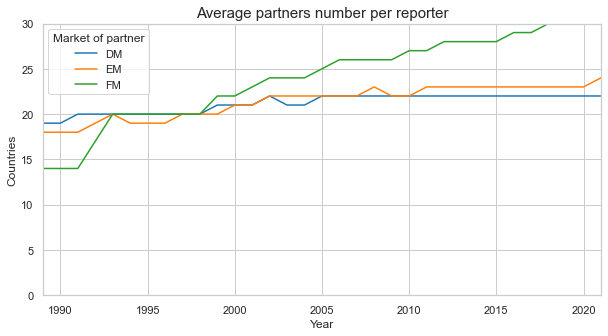

In [10]:
### STATS: IMPORT COVERAGE: PARTNERS NUMBER

### Adding regions of reporters and partners:
df_coverage_full = df_comm_full.join(ser_ison_status, on = 'Reporter', rsuffix = '_Reporter').join(ser_ison_status, on = 'Partner', rsuffix = '_Partner')
df_coverage_full.rename({'Market': 'Reporter_Market', 'Market_Partner': 'Partner_Market'}, axis = 1, inplace = True)
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_partners.name = 'Number'
### Region's partners number:
dict_partners['ISON']  = ser_iter_partners
for iter_region in list_region:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_partners.name = 'Number'
    dict_partners[iter_region]  = ser_iter_partners
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).reset_index()
df_to_plot = df_partners.rename({'level_0': 'Market of partner'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of partner')
ax_partners.set_title('Overall partners number', fontsize = 15)
ax_partners.set(xlim = (1989, 2021), ylim = (0, 90), ylabel = 'Countries')
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_region:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Number'
    dict_ave_partners[iter_region]  = ser_iter_partners
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).reset_index()
df_to_plot = df_partners.rename({'level_0': 'Market of partner'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of partner')
ax_partners.set_title('Average partners number per reporter', fontsize = 15)
ax_partners.set(xlim = (1989, 2021), ylim = (0, 30), ylabel = 'Countries')
plt.show()

UN Comtrade Import: Total ISON Reporters number: 85
UN Comtrade Import: Total Commodity types number: 26


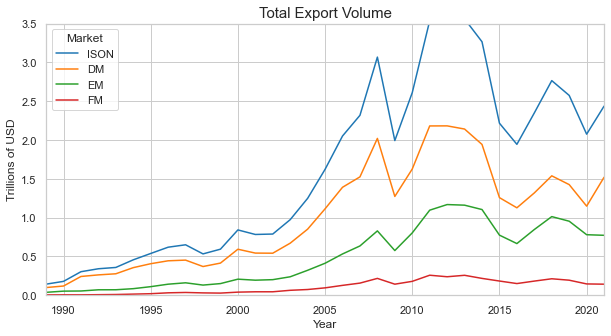

In [11]:
### STATS: IMPORT COVERAGE: WORDLEVEL GENERAL STATS

### Key numbers:
print('UN Comtrade Import: Total ISON Reporters number:', str(len(df_comm_world['Reporter'].unique())))
print('UN Comtrade Import: Total Commodity types number:', str(len(df_comm_world['Commodity_ID'].unique())))
### Total import volume calculation start:
dict_total_volume = {}
### ISON total volume:
ser_total_volume = df_comm_world.groupby('Date')['Value'].sum() / 1000000000000
dict_total_volume['ISON'] = ser_total_volume
df_comm_world_isoned = df_comm_world.join(ser_ison_status, on = 'Reporter')
### Region's total volume:
for iter_region in list_region:
    ser_iter_volume = df_comm_world_isoned[df_comm_world_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000000000
    dict_total_volume[iter_region] = ser_iter_volume
### Data consolidating:    
df_to_plot = pd.concat(dict_total_volume).reset_index()
df_to_plot.rename({'level_0': 'Market'}, axis = 1, inplace = True)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot.drop('Date', axis = 1)
### Total import volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Value', hue = 'Market')
ax_total.set_title('Total Import Volume', fontsize = 15)
ax_total.set(xlim = (1989, 2021), ylabel = 'Trillions of USD', ylim = (0.0, 3.5))
plt.show()

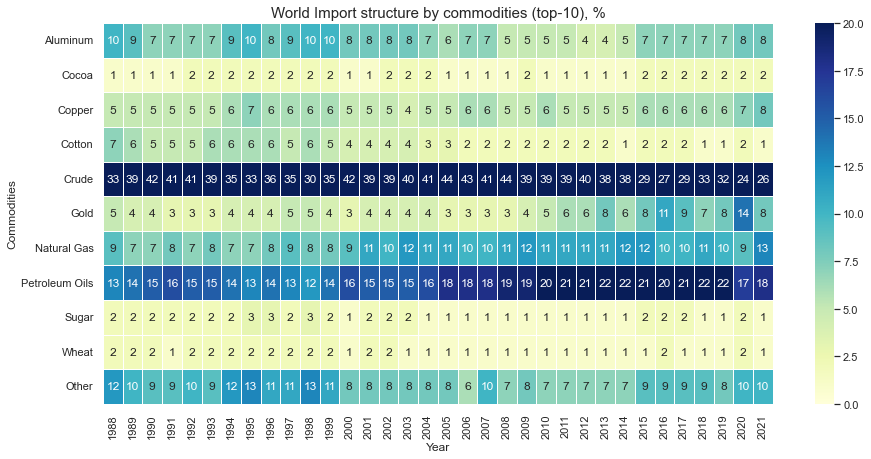

In [12]:
### STATS: WORDLEVEL IMPORT STRUCTURE BY COMMODITIES

gc.collect()
### Stats parameter - leaders to plot:
int_top = 10
### Commodity trade proprotion for each date:
ser_comm_value = df_comm_world.groupby(['Date', 'Commodity_Name'])['Value'].sum().dropna() / 1000000000
ser_total_value = df_comm_world.groupby(['Date'])['Value'].sum().dropna() / 1000000000
df_comm_part = (ser_comm_value / ser_total_value).round(2).reset_index()
df_comm_part['Year'] = df_comm_part['Date'].dt.year
ser_comm_part = df_comm_part.set_index(['Year', 'Commodity_Name']).drop('Date', axis = 1).squeeze()
### All-time commodity trade volume:
ser_comm_ave = ser_comm_part.groupby('Commodity_Name').sum().sort_values(ascending = False)
### Top commodities list:
idx_ave_top = ser_comm_ave[: int_top].index
### Other commodities list:
idx_ave_other = ser_comm_ave[int_top :].index
### Top commodities proportions extracting:
ser_comm_top = (ser_comm_part.loc[All, idx_ave_top] * 100)
ser_comm_top.index.set_levels(ser_comm_top.index.levels[1].astype('O'), level = 'Commodity_Name', inplace = True)
### Other commodities common proportion extracting:
ser_comm_other = (ser_comm_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_comm_other = pd.concat({'Other': ser_comm_other}, names = ['Commodity_Name']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_comm_top.sort_index().unstack('Year'), ser_comm_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f', center = 10, vmin = 0, vmax = 20)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title('World Import structure by commodities (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

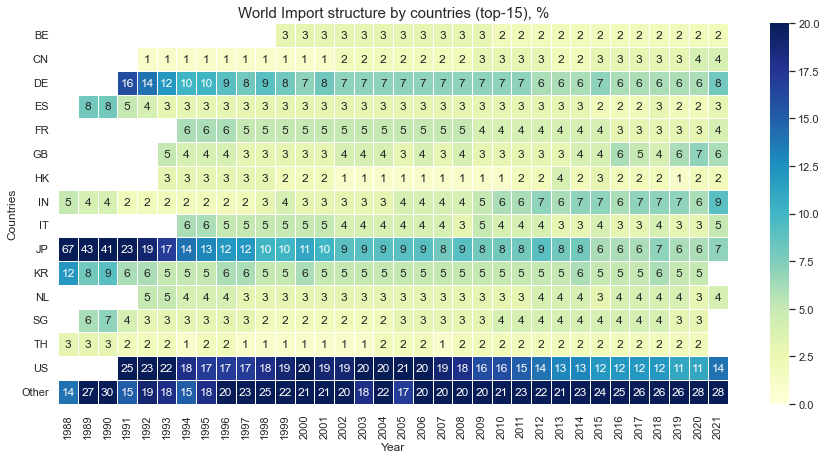

In [13]:
### STATS: WORDLEVEL IMPORT STRUCTURE BY COUNTRIES

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Country trade proprotion for each date:
ser_country_value = df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().dropna() / 1000000000
ser_total_value = df_comm_world.groupby(['Date'])['Value'].sum().dropna() / 1000000000
df_country_part = (ser_country_value / ser_total_value).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze()
### All-time country trade volume:
ser_country_ave = ser_country_part.groupby('Reporter').sum().sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_country_ave[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f', center = 10, vmin = 0, vmax = 20)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Import structure by countries (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

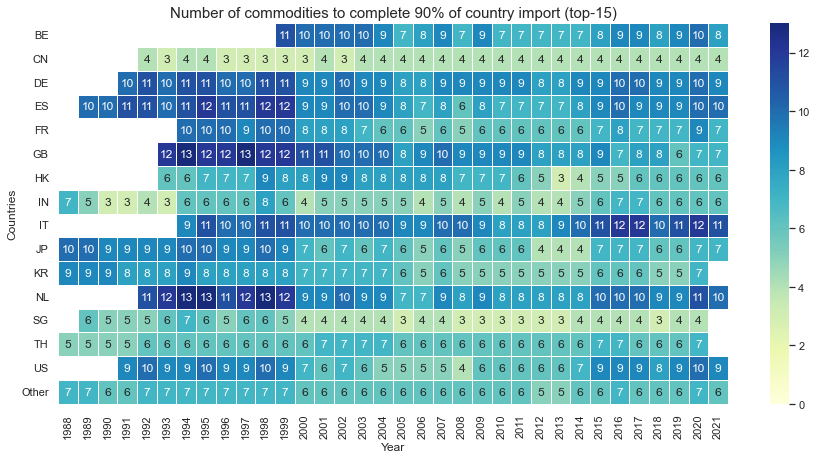

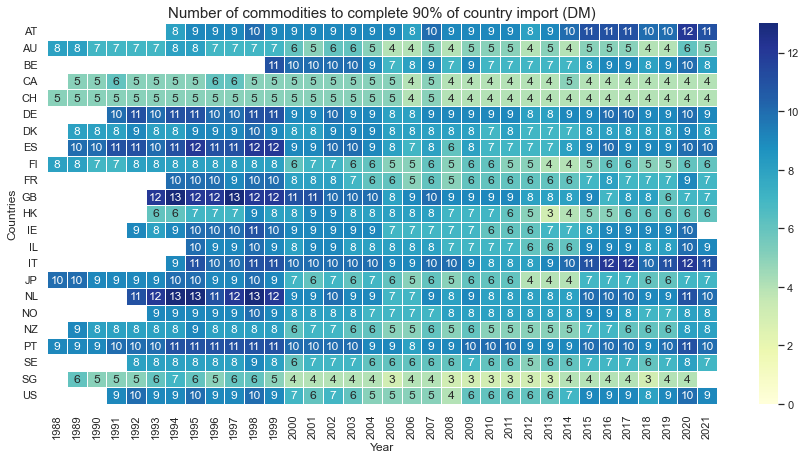

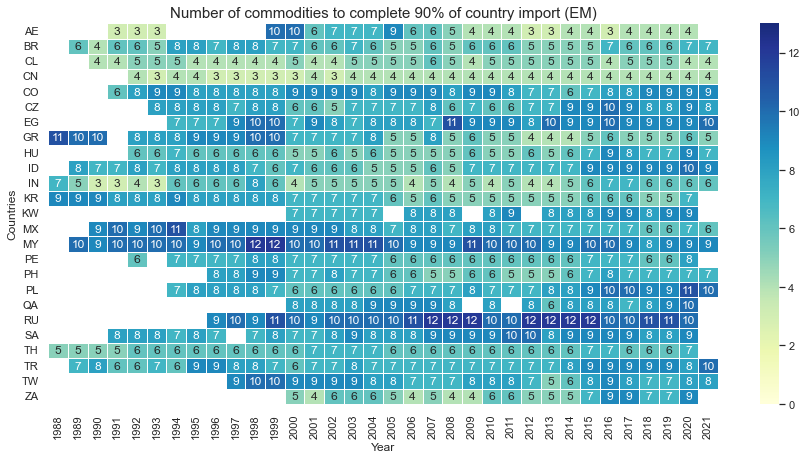

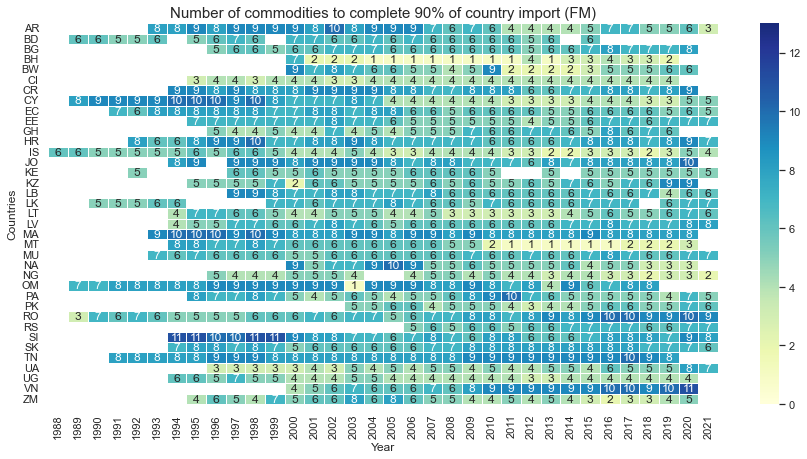

In [14]:
### STATS: NUMBER OF COMMODITIES TO COMPLETE TOP-% FOR COUNTRY

gc.collect()
### Defining top-% commodities number calculation procedure:
def get_top_comm(df_group, flo_perc):
    df_group = df_group.sort_values('Value', ascending = False).reset_index()
    ser_cum_sum = df_group['Value'].cumsum() / df_group['Value'].sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.90
### Stats parameter - leaders to plot:
int_top = 15
### Top-% commodities number calculation for each Date / Reporter pair:
ser_top_comm = df_comm_world.groupby(['Date', 'Reporter']).apply(get_top_comm, flo_perc).astype(int)
ser_top_comm.name = 'Number'
df_top_comm = ser_top_comm.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_top_comm[df_top_comm['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_top_comm[df_top_comm['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 7, vmin = 0, vmax = 13)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of commodities to complete ' + str(int(flo_perc * 100)) + '% of country import (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_top_comm.loc[df_top_comm['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 7, vmin = 0, vmax = 13)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of commodities to complete ' + str(int(flo_perc * 100)) + '% of country import (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()

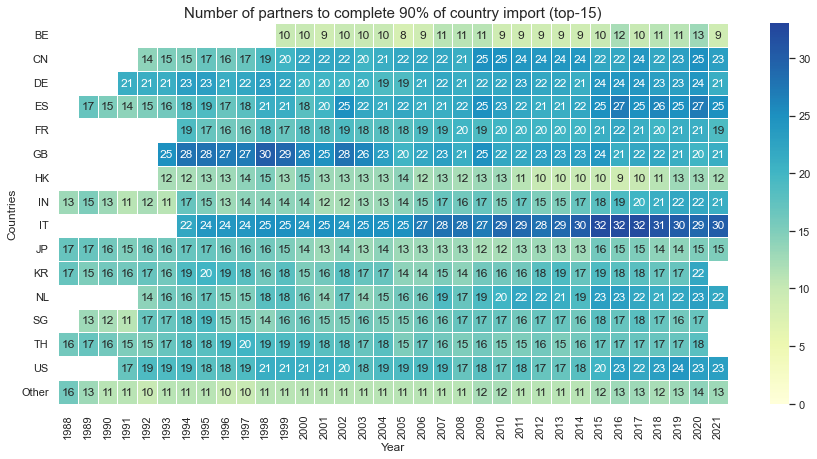

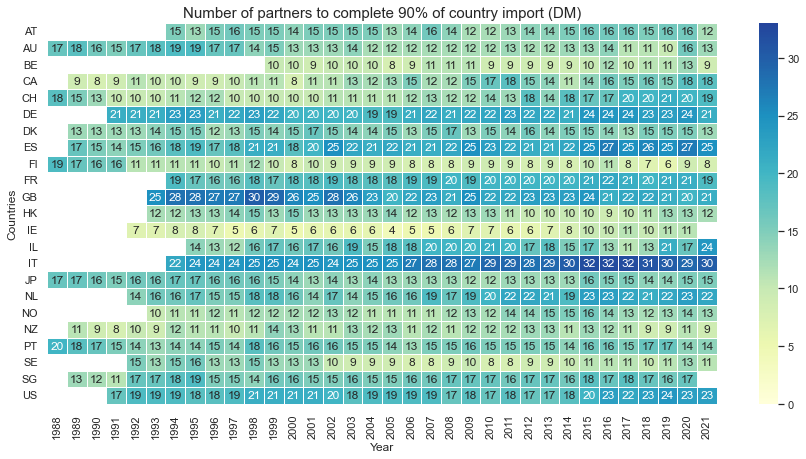

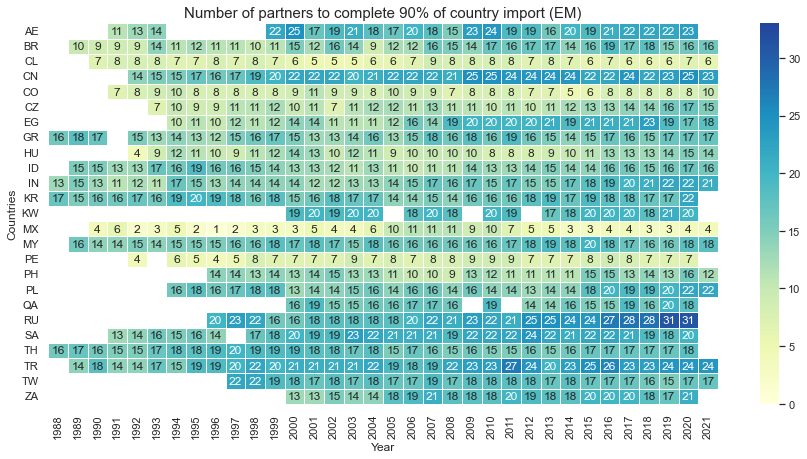

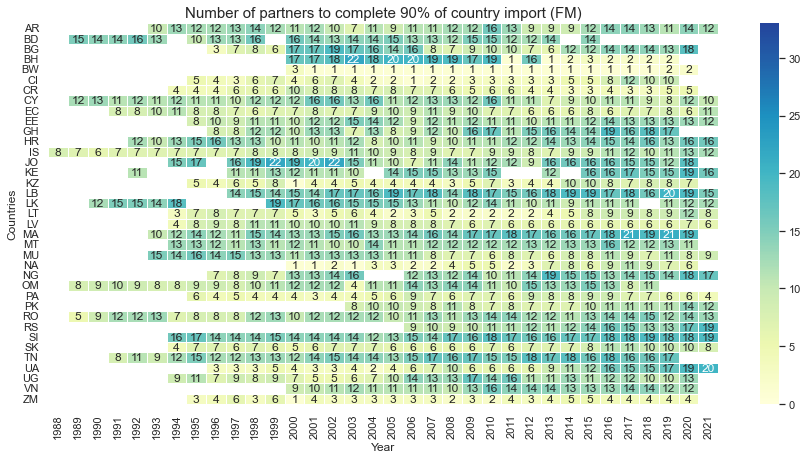

In [15]:
### STATS: NUMBER OF PARTNERS TO COMPLETE TOP-% FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(df_group, flo_perc):
    ser_by_partner = df_group.groupby(['Date', 'Partner'])['Value'].sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.90
### Stats parameter - leaders to plot:
int_top = 15
### Top-% partners number calculation for each Date / Reporter pair:
ser_top_partners = df_comm_full.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).astype(int)
ser_top_partners.name = 'Number'
df_top_partners = ser_top_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_top_partners[df_top_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_top_partners[df_top_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country import (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_top_partners.loc[df_top_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country import (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

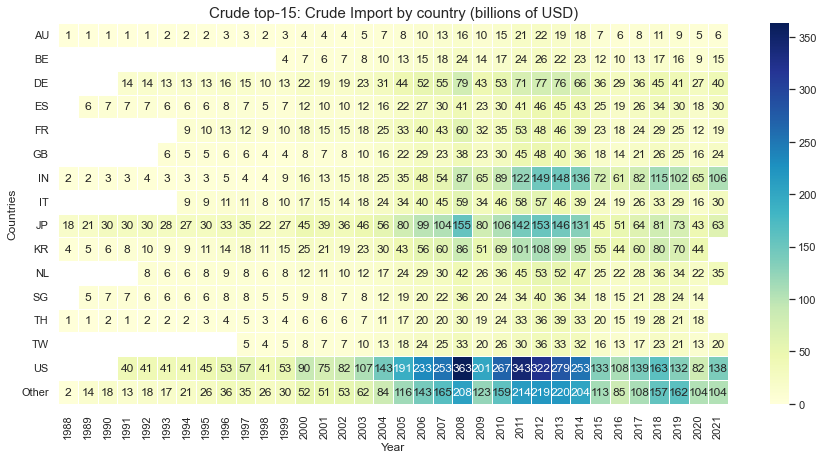

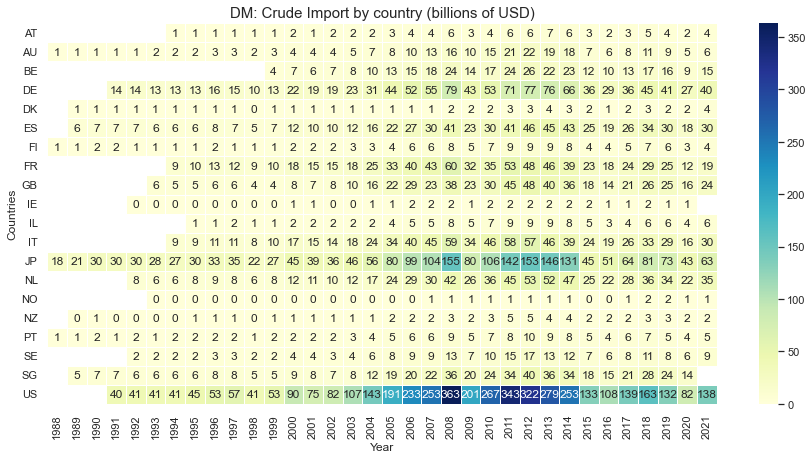

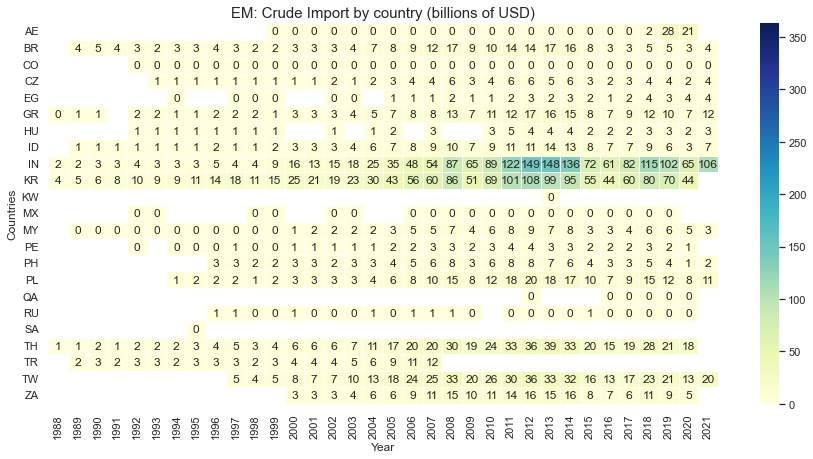

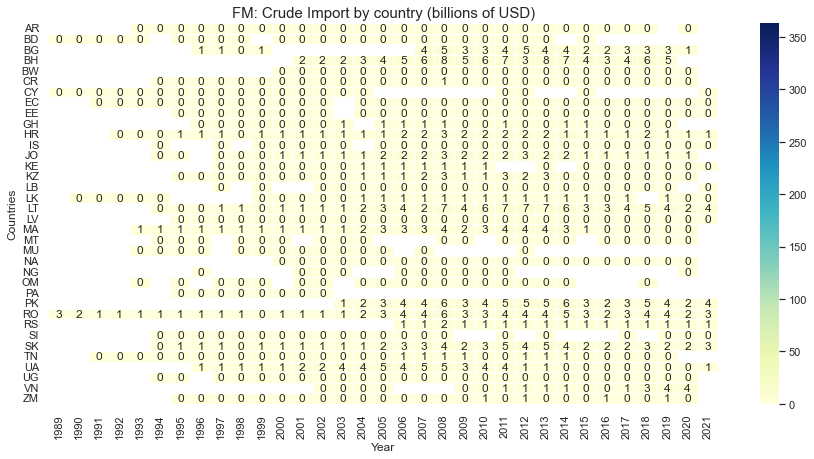

In [16]:
### STATS: COMMODITY IMPORT DISTRIBUTION, USD

### Stats parameter - commodity to plot:
str_comm = 'Crude'
### Stats parameter - leaders to plot:
int_top = 15
### ISON status adding:
df_comm_distr = df_comm_world[df_comm_world['Commodity_Name'] == str_comm].join(ser_ison_status, on = 'Reporter')
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Maximum value calculation:
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Date')['Value'].sum().astype('int64').reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Value'].unstack('Year') / 1000000000
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title(str_comm + ' top-' + str(int_top) + ': ' + str_comm + ' Import by country (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str_comm + ' Import by country (billions of USD)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

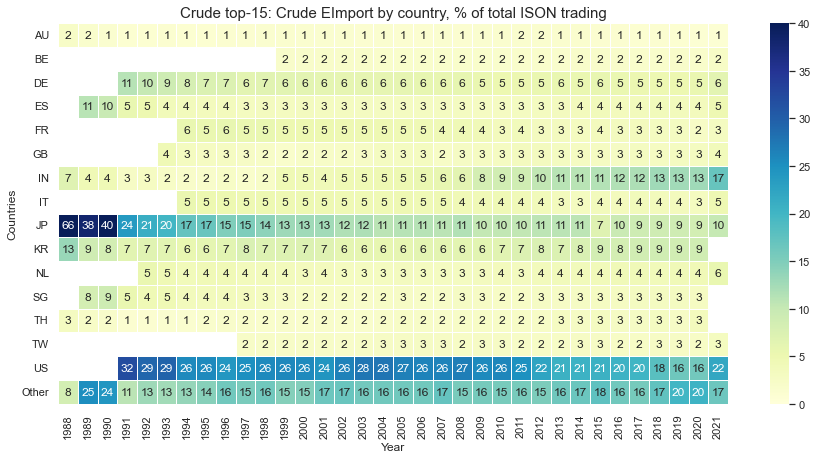

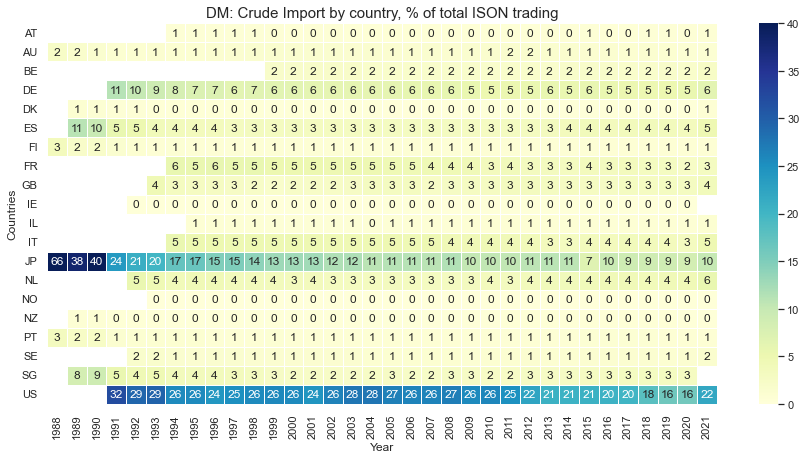

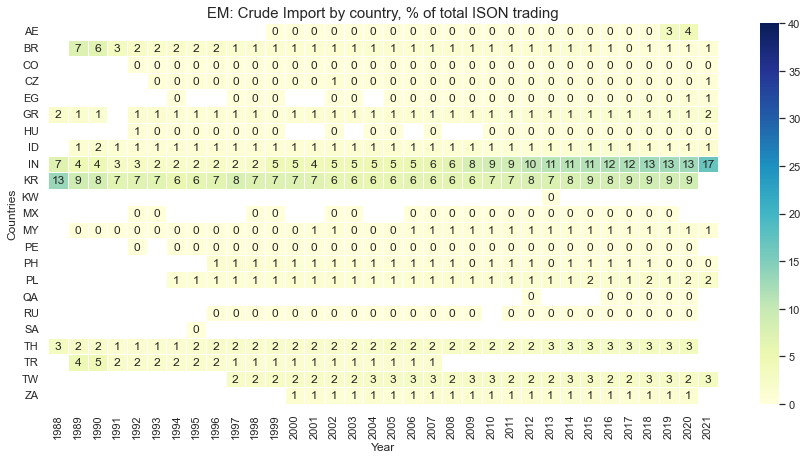

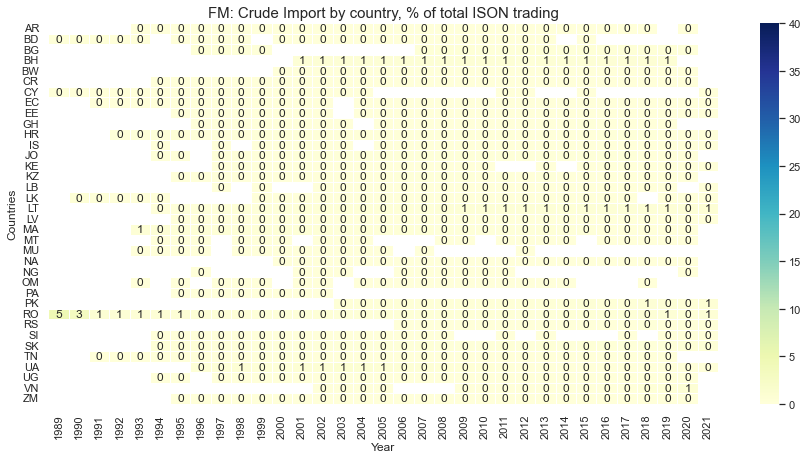

In [17]:
### NEW!!! ### STATS: COMMODITY IMPORT DISTRIBUTION, PROPORTION

### Stats parameter - commodity to plot:
str_comm = 'Crude'
### Stats parameter - leaders to plot:
int_top = 15
### ISON status adding:
df_comm_distr = df_comm_world[df_comm_world['Commodity_Name'] == str_comm].join(ser_ison_status, on = 'Reporter')
df_comm_distr['Proportion'] = df_comm_distr.groupby('Date')['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum())
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Proportion']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Date')['Proportion'].sum().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Proportion'].unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title(str_comm + ' top-' + str(int_top) + ': ' + str_comm + ' EImport by country, % of total ISON trading' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Proportion']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str_comm + ' Import by country, % of total ISON trading' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

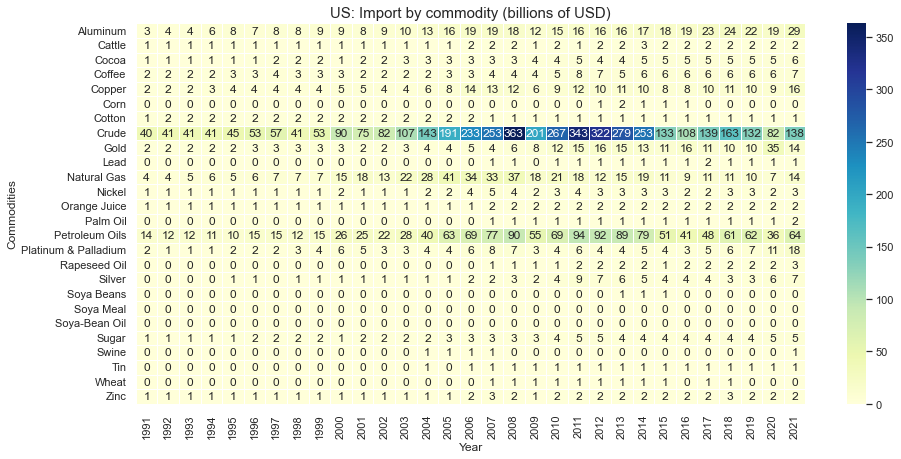

In [18]:
### STATS: COUNTRY IMPORT DISTRIBUTION, USD

### Stats parameter - country to slice:
str_country = 'US'
### Country slicing:
df_comm_distr = df_comm_world[df_comm_world['Reporter'] == str_country]
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Data extraction:
df_to_plot = df_comm_distr.copy()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot[['Year', 'Commodity_Name', 'Value']].set_index(['Commodity_Name', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Import by commodity (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

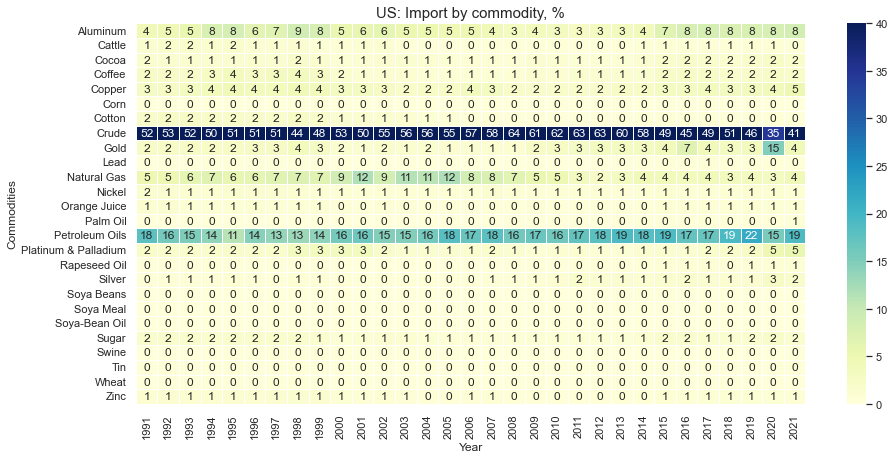

In [19]:
### NEW !!! ### STATS: COUNTRY IMPORT DISTRIBUTION, %

### Stats parameter - country to slice:
str_country = 'US'
### Country slicing:
df_comm_distr = df_comm_world[df_comm_world['Reporter'] == str_country].copy()
df_comm_distr['Proportion'] = df_comm_distr.groupby('Date')['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum())
### Data extraction:
df_to_plot = df_comm_distr.copy()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot[['Year', 'Commodity_Name', 'Proportion']].set_index(['Commodity_Name', 'Year']).squeeze().unstack('Year').sort_index()
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Import by commodity, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

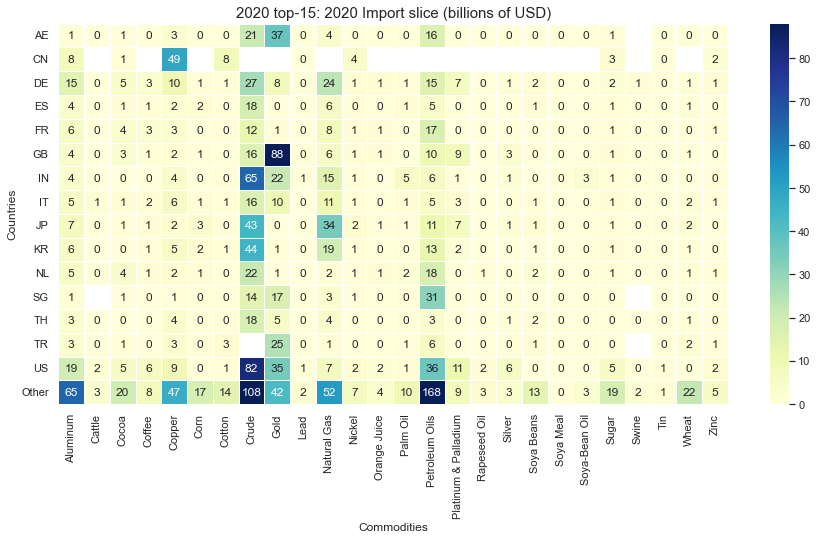

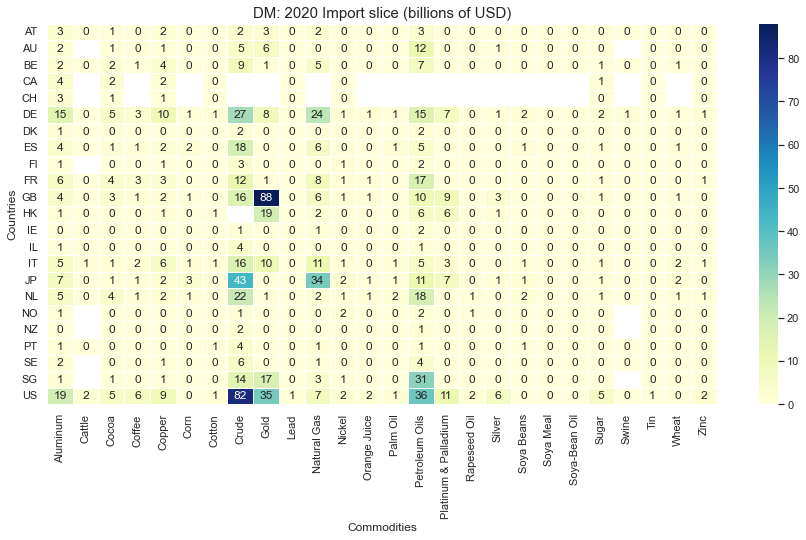

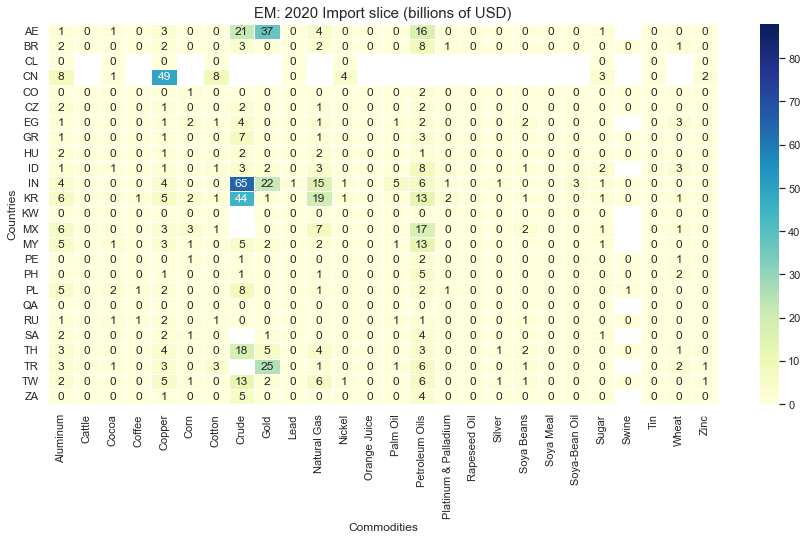

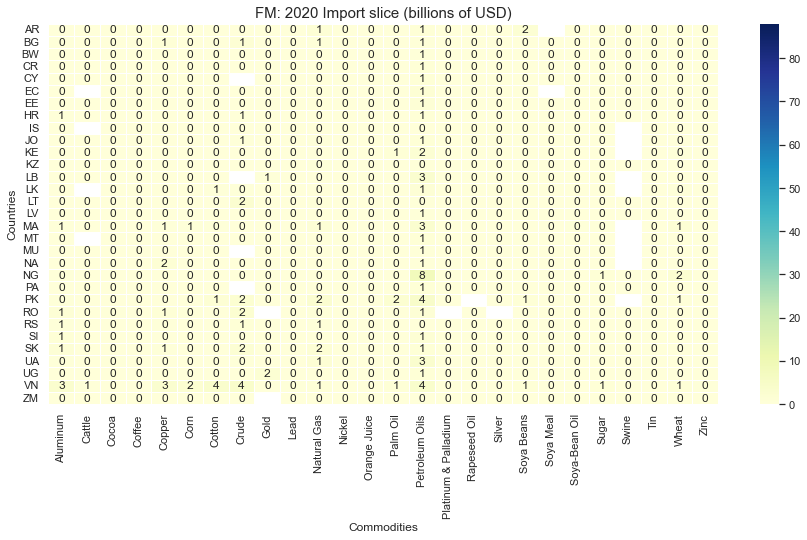

In [20]:
### STATS: YEAR SLICE: MEASURED BY USD

gc.collect()
### Stats parameter - year to slice:
int_year = 2020
### Stats parameter - leaders to plot:
int_top = 15
### Year slicing:
df_comm_distr = df_comm_world[df_comm_world['Date'].dt.year == int_year].join(ser_ison_status, on = 'Reporter')
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Maximum value defining:
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr.loc[df_comm_distr['Reporter'].isin(idx_ave_top), ['Reporter', 'Commodity_Name', 'Value']].copy()
df_top_part = df_top_part.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name') / 1000000000
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Commodity_Name')['Value'].sum().astype('int64').reset_index()
df_other_part = pd.concat({'Other': df_other_part.set_index('Commodity_Name')}, names = ['Reporter'])
df_other_part = df_other_part.squeeze().unstack('Commodity_Name')[df_top_part.columns] / 1000000000
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
ax_heatmap.set_title(str(int_year) + ' top-' + str(int_top) + ': ' + str(int_year) + ' Import slice (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region, ['Reporter', 'Commodity_Name', 'Value']].copy()
    df_to_plot = df_to_plot.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name') / 1000000000
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
    ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str(int_year) + ' Import slice (billions of USD)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

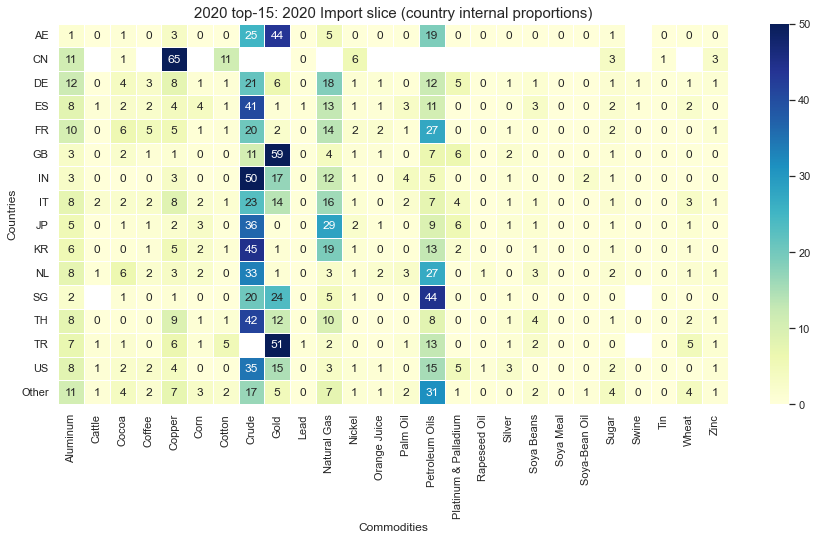

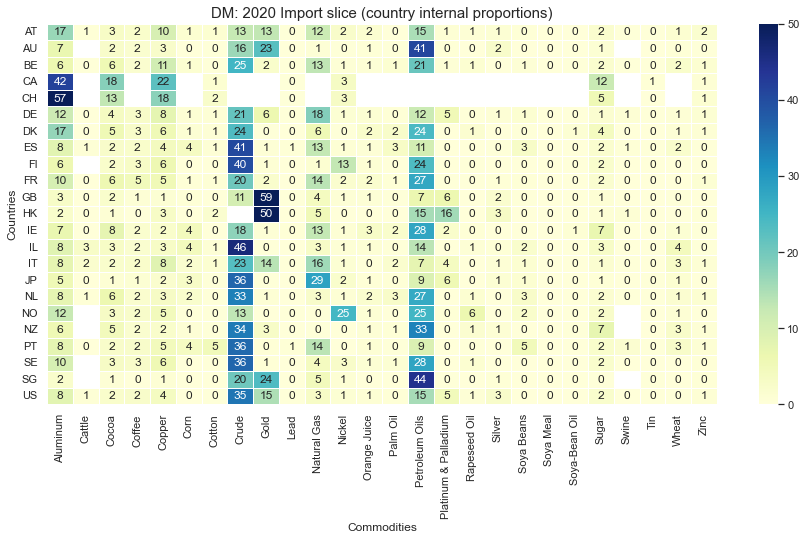

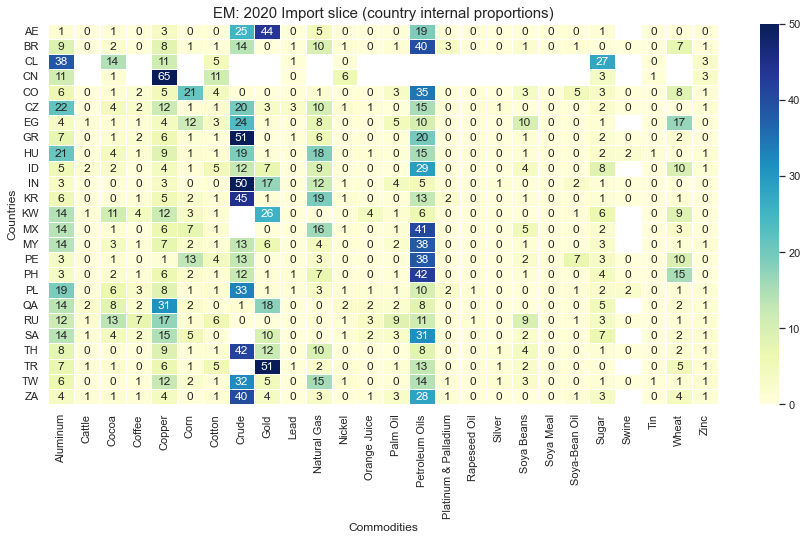

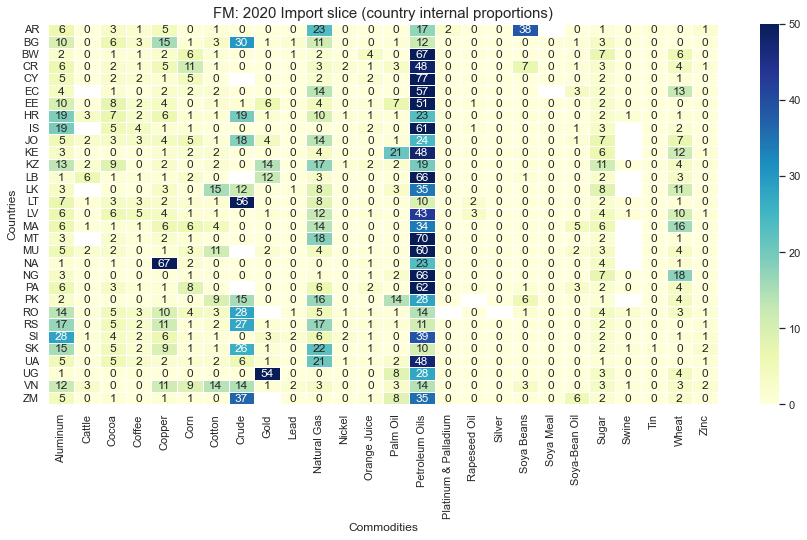

In [21]:
### STATS: YEAR SLICE: MEASURED BY COUNTRY INTERNAL %

gc.collect()
### Stats parameter - year to slice:
int_year = 2020
### Stats parameter - leaders to plot:
int_top = 15
### Year slicing:
df_comm_distr = df_comm_world[df_comm_world['Date'].dt.year == int_year].join(ser_ison_status, on = 'Reporter')
df_comm_distr['Proportion'] = df_comm_distr.groupby(['Reporter'])['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum())
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr.loc[df_comm_distr['Reporter'].isin(idx_ave_top), ['Reporter', 'Commodity_Name', 'Proportion']].copy()
df_top_part = df_top_part.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name')
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Commodity_Name')['Proportion'].mean().reset_index()
df_other_part = pd.concat({'Other': df_other_part.set_index('Commodity_Name')}, names = ['Reporter'])
df_other_part = df_other_part.squeeze().unstack('Commodity_Name')[df_top_part.columns]
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 25, vmin = 0, vmax = 50)
ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
ax_heatmap.set_title(str(int_year) + ' top-' + str(int_top) + ': ' + str(int_year) + ' Import slice (country internal proportions)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction: 
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region, ['Reporter', 'Commodity_Name', 'Proportion']].copy()
    df_to_plot = df_to_plot.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name')
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 25, vmin = 0, vmax = 50)
    ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str(int_year) + ' Import slice (country internal proportions)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

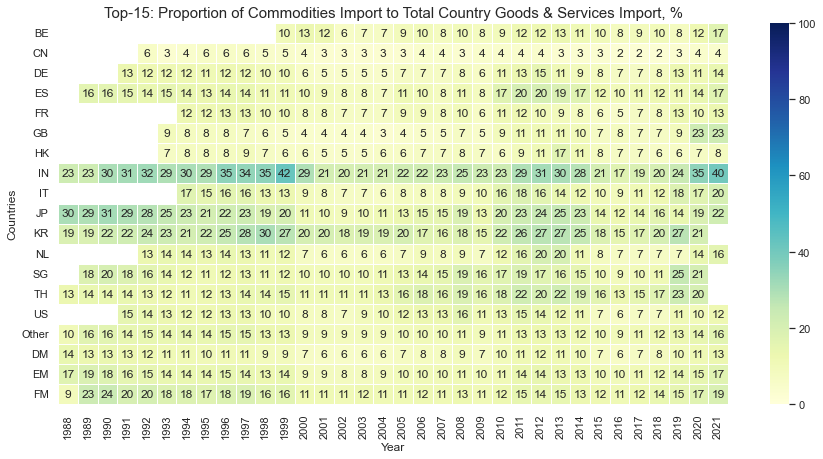

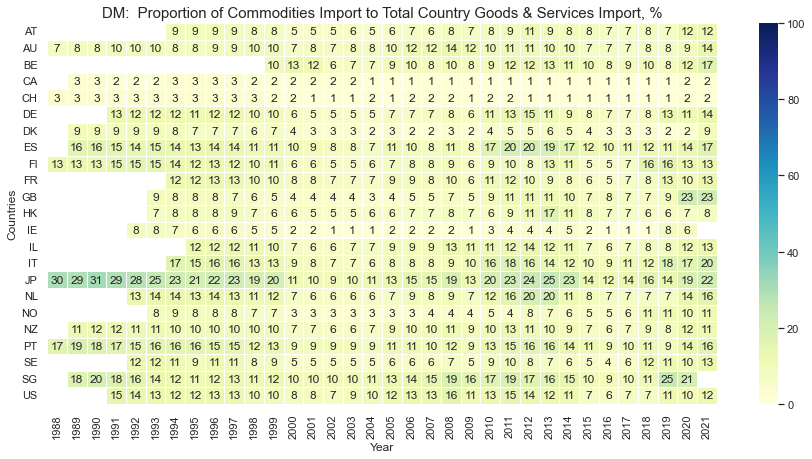

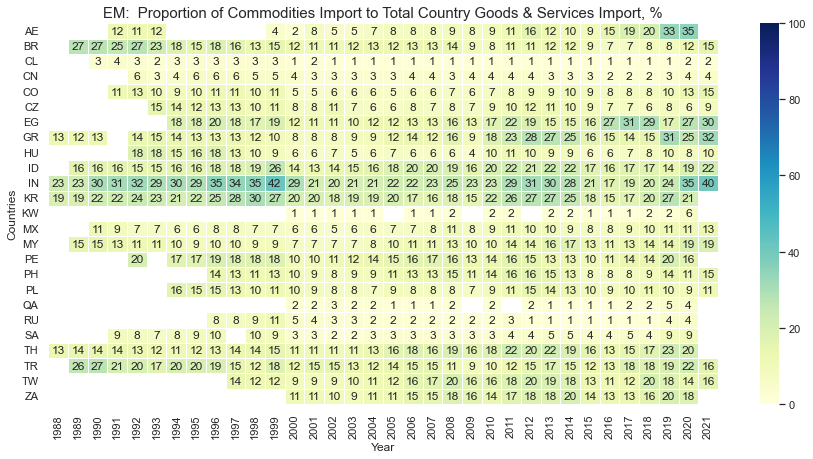

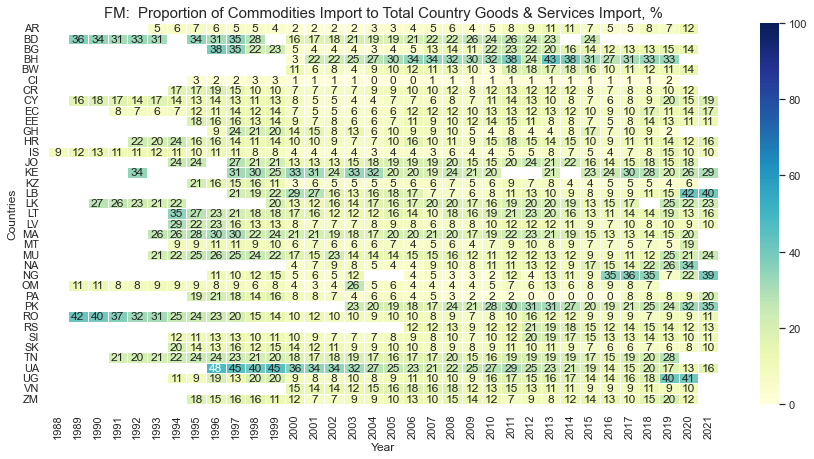

In [22]:
### STATS: COMMODITIES IMPORT PROPORTION IN OVERALL COUNTRY GOODS & SERVICES IMPORT

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Global import data loading:
df_global_world = pd.read_hdf(path_or_buf = str_path_global, key = str_key_unc, where = 'Flow = Import').droplevel('Flow')
### Proportion calculating:
ser_comm_proportion = (df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().dropna() * 100 / df_global_world).round(0)
df_comm_proportion = ser_comm_proportion.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_proportion.loc[df_comm_proportion['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_proportion[df_comm_proportion['Reporter'].isin(idx_ave_other)].groupby('Date')['Value'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Value'].squeeze().unstack('Year')
### Region's average values:
list_regions_ave = []
for iter_region in list_region:
    df_iter_part = df_comm_proportion[df_comm_proportion['Market'] == iter_region].groupby('Date')['Value'].mean().reset_index()
    df_iter_part['Year'] = df_iter_part['Date'].dt.year
    df_iter_part = pd.concat({iter_region: df_iter_part.set_index('Year')}, names = ['Reporter'])
    df_iter_part = df_iter_part['Value'].squeeze().unstack('Year')
    list_regions_ave.append(df_iter_part)
df_regions = pd.concat(list_regions_ave, axis = 0)
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part, df_regions], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ': ' + 'Proportion of Commodities Import to Total Country Goods & Services Import, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_proportion.loc[df_comm_proportion['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + ' Proportion of Commodities Import to Total Country Goods & Services Import, %' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

ISON sum > World sum:


Series([], Name: Value, dtype: float64)

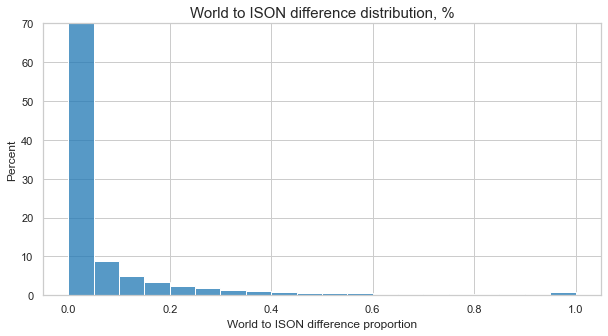

In [23]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON IMPORT: DATE / REPORTER / COMMODITY LEVEL DISTRIBUTION

gc.collect
### Stats parameter:
flo_error = -0.01
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_diff = ((ser_comm_world - ser_comm_ison) / ser_comm_world).dropna()
print('ISON sum > World sum:')
display(ser_comm_diff[ser_comm_diff < flo_error])
### Turning negative proportions to zeroes:
ser_comm_diff.clip(lower = 0.0, inplace = True)
### Differences plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_hist = sns.histplot(data = ser_comm_diff.reset_index(), x = 'Value', bins = 20, binrange = (0.0, 1.0), stat = 'percent')
ax_hist.set(xlabel = 'World to ISON difference proportion', ylim = (0, 70))
ax_hist.set_title('World to ISON difference distribution, %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
#display(df_comm_full[(df_comm_full['Reporter'] == 'CH') & (df_comm_full['Date'] == '2013-12-31')].groupby('Commodity_Name')['Value'].sum())
#display(df_comm_world[(df_comm_world['Reporter'] == 'CH') & (df_comm_world['Date'] == '2013-12-31')])

ISON sum > World sum:


Series([], Name: Not_Covered, dtype: float64)

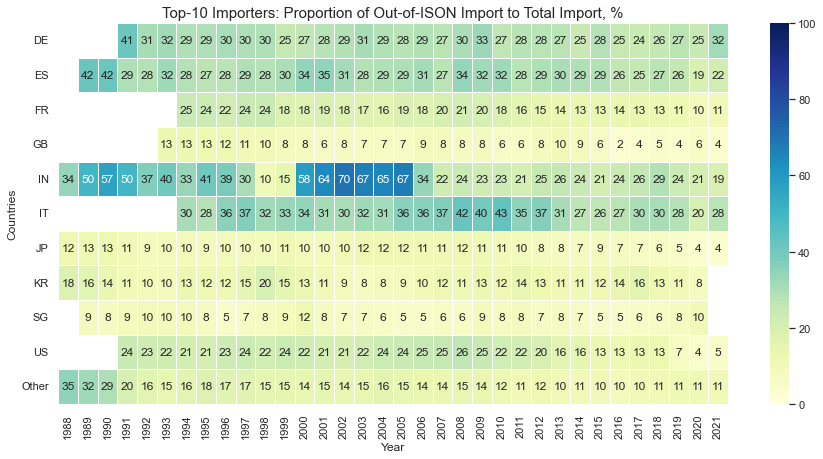

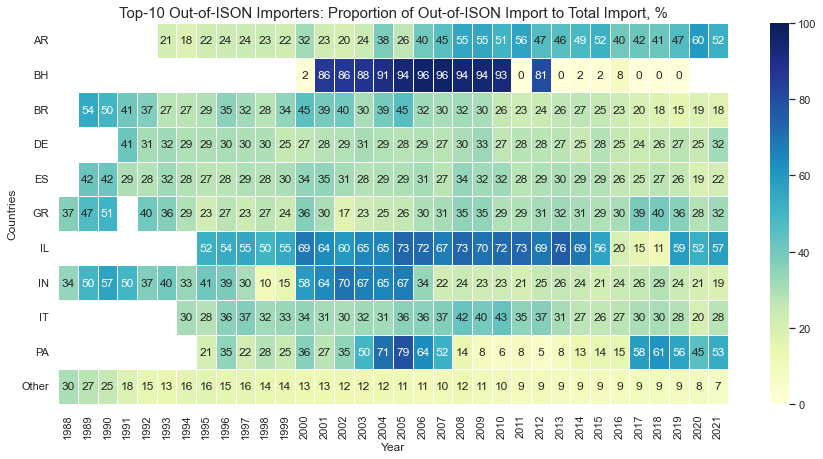

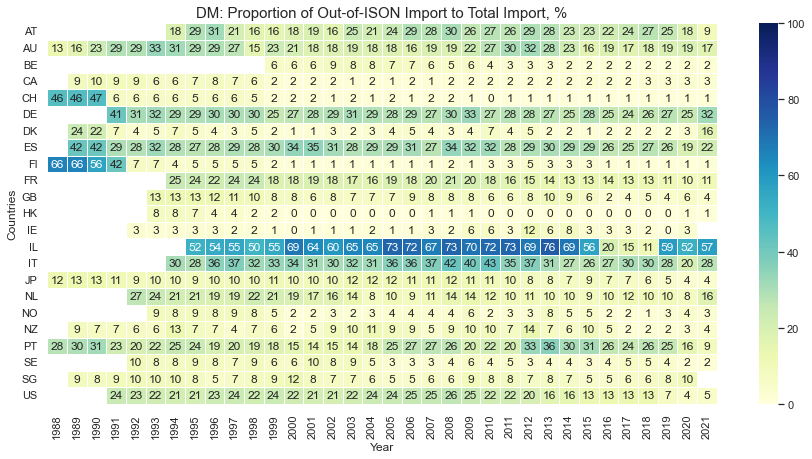

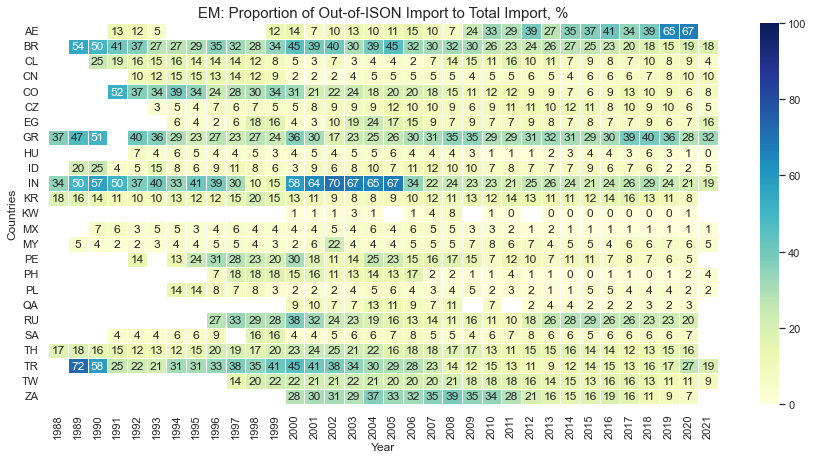

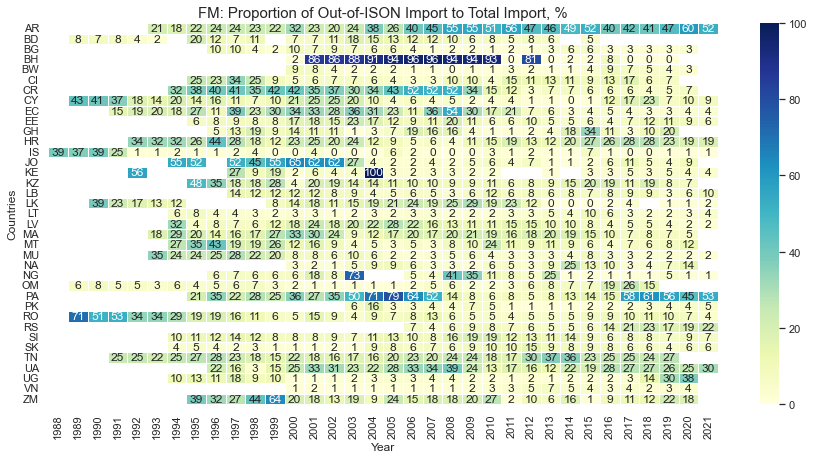

In [24]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON IMPORT: DATE / REPORTER

gc.collect
### Stats parameter:
flo_error = -0.01
### Top number:
int_top = 10
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_sum = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_sum = df_comm_sum.groupby(['Date', 'Reporter']).sum()
ser_comm_diff = (1 - df_comm_sum['Total_ISON'] / df_comm_sum['World']) * 100
ser_comm_diff.name = 'Not_Covered'
print('ISON sum > World sum:')
display(ser_comm_diff[ser_comm_diff < flo_error])
ser_comm_ave = ser_comm_diff.groupby('Reporter').mean().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_country_ave[int_top :].index  
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Importers: ' + 'Proportion of Out-of-ISON Import to Total Import, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Externat trade countries list:
idx_ave_top = ser_comm_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_comm_ave[int_top :].index  
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Out-of-ISON Importers: ' + 'Proportion of Out-of-ISON Import to Total Import, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
df_comm_diff = ser_comm_diff.to_frame().join(ser_ison_status, on = 'Reporter')
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_diff.loc[df_comm_diff['Market'] == iter_region].copy().reset_index()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + 'Proportion of Out-of-ISON Import to Total Import, %' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

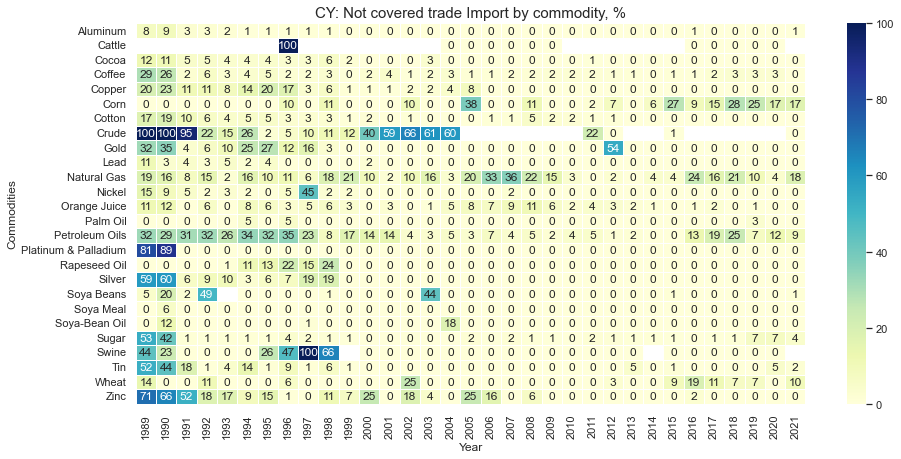

In [25]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON IMPORT: COUNTRY DETALIZATION, % NOT COVERED

### Country slice
str_country = 'CY' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (1 - df_comm_compare['Total_ISON'] / df_comm_compare['World']).clip(lower = 0.0)
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
df_to_plot = df_comm_compare.loc[df_comm_compare['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year')
df_to_plot = df_to_plot.sort_index() * 100
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Not covered trade Import by commodity, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()

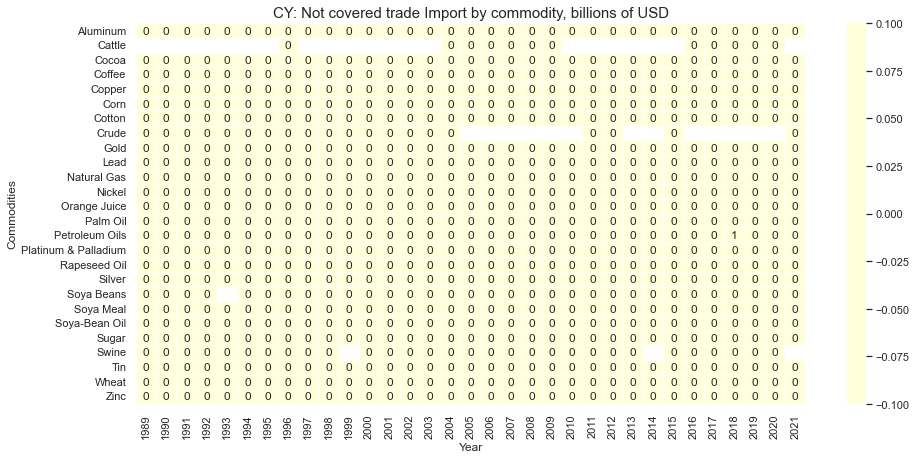

In [26]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON IMPORT: COUNTRY DETALIZATION, USD NOT COVERED

### Country slice
str_country = 'CY' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (df_comm_compare['World'] - df_comm_compare['Total_ISON']).clip(lower = 0.0)
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
df_to_plot = df_comm_compare.loc[df_comm_compare['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year')
df_to_plot = df_to_plot.sort_index()
int_max = int(df_to_plot.max().max())
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Not covered trade Import by commodity, billions of USD' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()

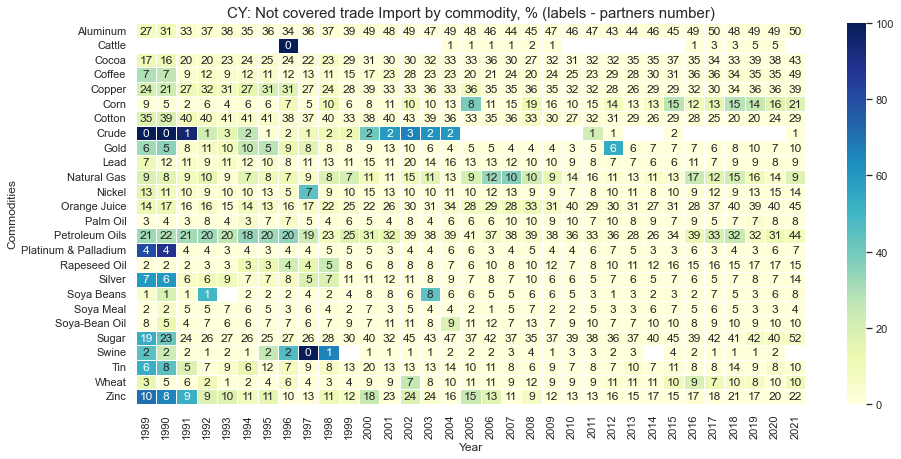

In [27]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON IMPORT: COUNTRY DETALIZATION, PARAMETERS TO CHOOSE

### Country slice
str_country = 'CY' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
### Container for different comparision metrics:
dict_comm_compare = {}
dict_title_suffix = {}
### Comparision by proportion, %:
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (1 - df_comm_compare['Total_ISON'] / df_comm_compare['World']).clip(lower = 0.0) * 100
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Proportion'] = df_comm_compare
dict_title_suffix['Proportion'] = '%'
### Comparision by value:
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (df_comm_compare['World'] - df_comm_compare['Total_ISON']).clip(lower = 0.0)
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Value'] = df_comm_compare
dict_title_suffix['Value'] = 'billions of USD'
### Comparision by partners number:
ser_comm_compare = df_comm_full.groupby(['Date', 'Commodity_Name', 'Reporter'])['Value'].count().astype(int)
df_comm_compare = ser_comm_compare.unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Partners'] = df_comm_compare
dict_title_suffix['Partners'] = 'partners number'
### Options selecting:
str_colors = 'Proportion'
str_labels = 'Partners'
### Tables loading:
df_colors = dict_comm_compare[str_colors]
df_labels = dict_comm_compare[str_labels]
### Data table preparation:
df_to_plot = df_colors.loc[df_colors['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year').sort_index()
#int_max = max(int(df_to_plot.max().max()), 100)
int_max = int(df_to_plot.max().max())
df_to_annot = df_labels.loc[df_labels['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year').sort_index().fillna(0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(data = df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, 
                         annot = df_to_annot, fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Not covered trade Import by commodity, ' + dict_title_suffix[str_colors] + ' (labels - ' + dict_title_suffix[str_labels] + ')', 
                     fontsize = 15)
plt.yticks(rotation = 0)
plt.show()

(Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


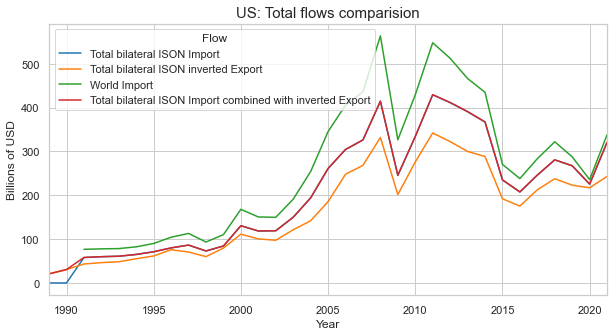

In [29]:
### EXAMPLE: EXPORT ANALYSIS: DATA PREPARATION

gc.collect()
### Country to slice:
str_country = 'US' # 'US' # 'SA' # 
### Import bilateral data loading and inverting:
df_export = get_comtrade_data(str_flow = 'Export', str_flag = [0, 1], str_partner = str_country).reset_index()
df_export_inverted = df_export[['Date', 'Partner', 'Reporter', 'Commodity_Name', 'Value']]
df_export_inverted.columns = ['Date', 'Reporter', 'Partner', 'Commodity_Name', 'Value']
ser_export_inverted = df_export_inverted.set_index(['Date', 'Partner', 'Commodity_Name'])['Value']
ser_export_inverted.name = 'Export_Inverted'
### Aggregating with bilateral Import data:
ser_import = df_comm_full.set_index(['Date', 'Reporter', 'Partner', 'Commodity_Name'])['Value']
ser_import.name = 'Import'
ser_import = ser_import.loc[All, str_country, All, All]
df_flows_compare = pd.concat([ser_import, ser_export_inverted], axis = 1).sort_index()
df_flows_total = (df_flows_compare.groupby('Date').sum()/ 1000000000)
df_flows_total.columns = ['Total bilateral ISON Import', 'Total bilateral ISON inverted Export']
### Aggregating with world Import data:
ser_world_import = df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().loc[All, str_country] / 1000000000
ser_world_import.name = 'World Import'
df_flows_total = df_flows_total.join(ser_world_import)
### Aggregating with Import combined with inverted Export data:
ser_import_augmented = ser_import.combine_first(ser_export_inverted).groupby('Date').sum() / 1000000000
ser_import_augmented.name = 'Total bilateral ISON Import combined with inverted Export'
df_flows_total = df_flows_total.join(ser_import_augmented)
### Preparing to plot:
df_to_plot = df_flows_total.reset_index() 
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.drop('Date', axis = 1, inplace = True)
df_to_plot = df_to_plot.melt(id_vars = ['Year'], var_name = 'Flow', value_name = 'Value')
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Value', hue = 'Flow')
ax_flows.set_title(str_country + ': Total flows comparision', fontsize = 15)
ax_flows.set(xlim = (1989, 2021), ylabel = 'Billions of USD')
plt.show()

In [30]:
### EXAMPLE: COMPLETING IMPORT WITH EXPORT OBSERVATIONS

print(str_country, ': Import observations count:', ser_import.count())
print(str_country, ': Import total, billions of USD:', (ser_import.sum() / 1000000000).round(2))
print(str_country, ': Inverted Export observations count:', ser_export_inverted.count())
print(str_country, ': Inverted Export total, billions of USD:', (ser_export_inverted.sum() / 1000000000).round(2))
print(str_country, ': Import added with inverted Export observations count:', ser_import.combine_first(ser_export_inverted).count())
print(str_country, ': Import added with inverted Export observations total, billions of USD:', 
      (ser_import.combine_first(ser_export_inverted).sum() / 1000000000).round(2))
print(str_country, ': World Import total, billions of USD:', (ser_world_import.sum()).round(2))

US : Import observations count: 29715
US : Import total, billions of USD: 6616.61
US : Inverted Export observations count: 31066
US : Inverted Export total, billions of USD: 5431.93
US : Import added with inverted Export observations count: 35963
US : Import added with inverted Export observations total, billions of USD: 6675.61
US : World Import total, billions of USD: 8184.59


ISON sum > World sum:


Series([], Name: Not_Covered, dtype: float64)

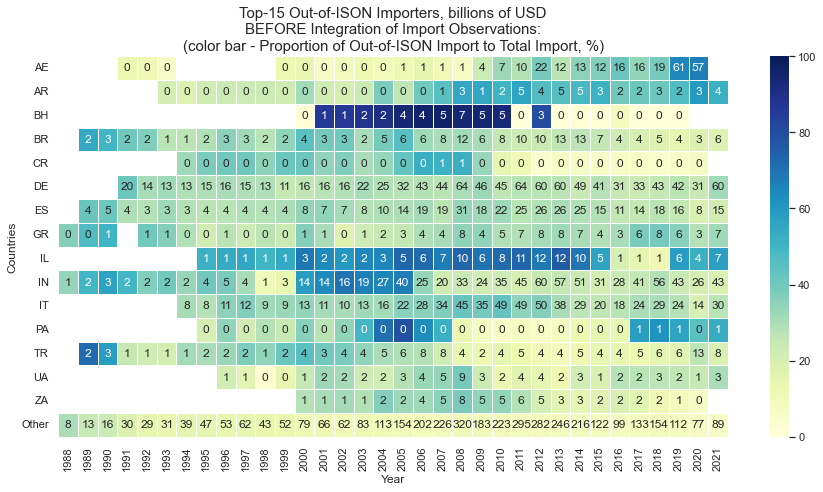

In [31]:
### EXPORT OBSERVATIONS INCORPORATION RESULTS ILLUSTRATING: BEFORE COMLPLETING

gc.collect
### Stats parameter:
flo_error = -0.01
### Top number:
int_top = 15
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_sum = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_sum = df_comm_sum.groupby(['Date', 'Reporter']).sum()
ser_comm_diff = (1 - df_comm_sum['Total_ISON'] / df_comm_sum['World']) * 100
ser_comm_diff.name = 'Not_Covered'
ser_comm_value = (df_comm_sum['World'] - df_comm_sum['Total_ISON']).clip(lower = 0).astype(int)
ser_comm_value.name = 'Not_Covered'
print('ISON sum > World sum:')
display(ser_comm_diff[ser_comm_diff < flo_error])
ser_comm_ave = ser_comm_diff.groupby('Reporter').mean().sort_values(ascending = False)
### Externat trade countries list:
idx_ave_top = ser_comm_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_comm_ave[int_top :].index  
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_value.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_value.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].sum().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_annotate = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = df_to_annotate, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Out-of-ISON Importers, billions of USD\n' + 
                     'BEFORE Integration of Import Observations:\n' + 
                     '(color bar - Proportion of Out-of-ISON Import to Total Import, %)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

In [34]:
### TEMP

ser_export_inverted

Date        Partner  Commodity_Name
1988-12-30  AU       Coffee               73061
                     Soya Beans            8661
                     Soya Meal           327006
                     Sugar              6860058
                     Cocoa               379343
                                         ...   
2021-12-31  UA       Gold                  8409
                     Copper            16972588
                     Nickel               29954
                     Aluminum           2748556
                     Zinc                   424
Name: Export_Inverted, Length: 31066, dtype: int64

(Flow in str_flow) & (Flag in str_flag)


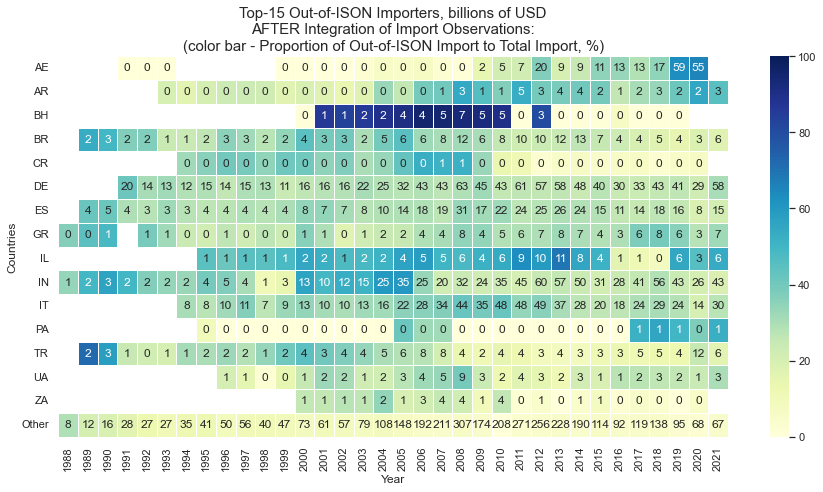

In [35]:
### EXPORT OBSERVATIONS INCORPORATION RESULTS ILLUSTRATING: AFTER COMLPLETING

gc.collect
### Stats parameter:
flo_error = -0.01
### Top number:
int_top = 15
### Export bilateral data loading and inverting:
df_export = get_comtrade_data(str_flow = 'Export', str_flag = [0, 1]).reset_index()
df_export_inverted = df_export[['Date', 'Partner', 'Reporter', 'Commodity_Name', 'Value']]
df_export_inverted.columns = ['Date', 'Reporter', 'Partner', 'Commodity_Name', 'Value']
ser_export_inverted = df_export_inverted.set_index(['Date', 'Reporter', 'Partner', 'Commodity_Name'])['Value']
ser_export_inverted.name = 'Export_Inverted'
### Import preparing:
ser_import = df_comm_full.set_index(['Date', 'Reporter', 'Partner', 'Commodity_Name'])['Value'].astype('int64')
ser_import.name = 'Import'
df_comm_augmented = ser_import.combine_first(ser_export_inverted).reset_index()
df_comm_augmented.rename({'Import': 'Value'}, axis = 1, inplace = True)
### ISON total trade:
ser_comm_ison = df_comm_augmented.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum().fillna(0.0)
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_sum = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_sum = df_comm_sum.groupby(['Date', 'Reporter']).sum()
ser_comm_diff = (1 - df_comm_sum['Total_ISON'] / df_comm_sum['World']) * 100
ser_comm_diff.name = 'Not_Covered'
ser_comm_value = (df_comm_sum['World'] - df_comm_sum['Total_ISON']).clip(lower = 0).astype(int)
ser_comm_value.name = 'Not_Covered'
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_value.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_value.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].sum().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_annotate = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = df_to_annotate, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Out-of-ISON Importers, billions of USD\n' + 
                     'AFTER Integration of Import Observations:\n' + 
                     '(color bar - Proportion of Out-of-ISON Import to Total Import, %)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

In [7]:
### EXPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

### Data loading:
ser_import = get_comtrade_data(str_flow = 'Import', str_flag = [0, 1])
ser_export = get_comtrade_data(str_flow = 'Export', str_flag = [0, 1])
### Data concatenation:
ser_flows = pd.concat([ser_export, ser_import], axis = 0).droplevel(['Flag'])\
             .to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()
ser_flows = ser_flows[ser_flows.index.get_level_values('Partner') != 'World']

(Flow in str_flow) & (Flag in str_flag)
(Flow in str_flow) & (Flag in str_flag)


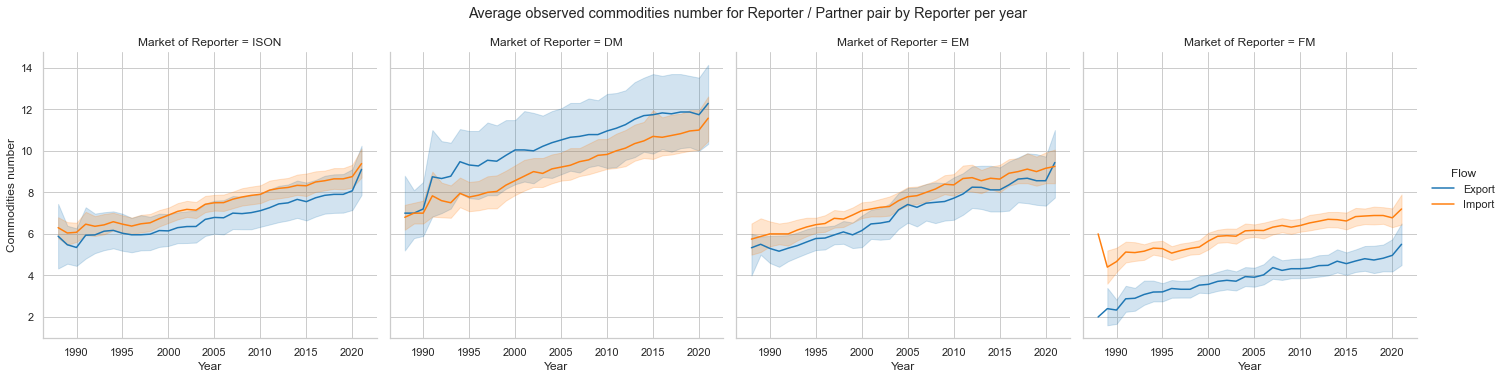

In [8]:
### EXPORT OBSERVATIONS INCORPORATION: COVERAGE COMPARING

### Average commodities number for Date / Reporter (Date / Reporter / Partner observations averaged) calculation:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Partner', 'Flow', 'Market']).count().groupby(['Date', 'Reporter', 'Flow', 'Market']).mean()
dict_obs_mean['ISON'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_region:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Market of Reporter', hue = 'Flow', kind = 'line')
fig_mean_obs.fig.suptitle('Average observed commodities number for Reporter / Partner pair by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Commodities number')
plt.show()

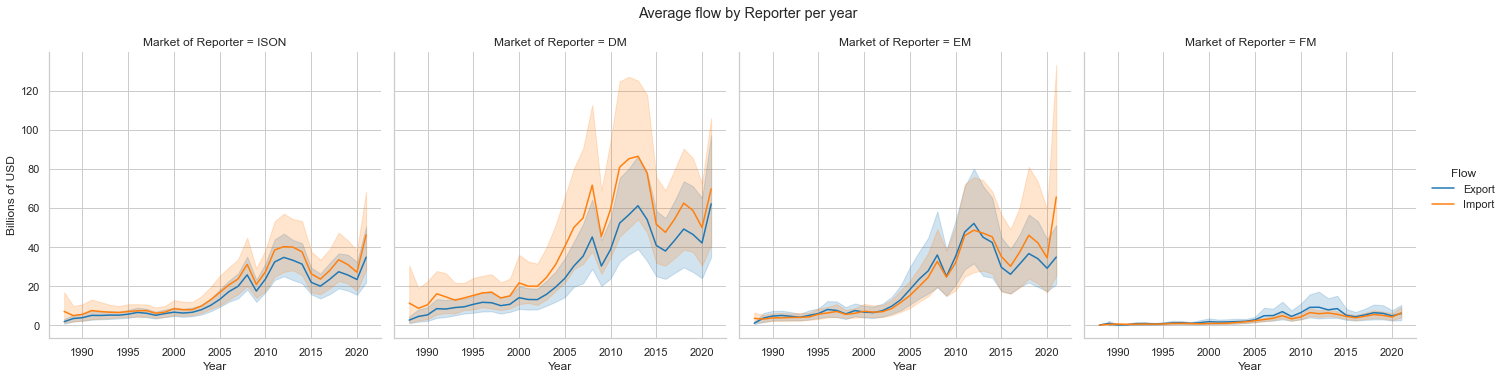

In [9]:
### EXPORT OBSERVATIONS INCORPORATION: VOLUME COMPARING

### Average commodities number for Date / Reporter (Date / Reporter / Partner observations averaged) calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows.groupby(['Date', 'Reporter', 'Flow', 'Market']).sum() / 1000000000
dict_obs_sum['ISON'] = ser_reporter_sum.round(0).droplevel('Market').round(2).dropna()
for iter_region in list_region:
    dict_obs_sum[iter_region] = ser_reporter_sum.loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Market of Reporter', hue = 'Flow', kind = 'line')
fig_mean_obs.fig.suptitle('Average flow by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
plt.show()

In [10]:
### EXPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()

ser_export_rev = ser_export[:]
ser_export_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_export_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_export_rev.index.set_names('Partner', level = 1, inplace = True)
ser_export_rev = ser_export_rev.swaplevel('Reporter', 'Partner').sort_index()
df_import_aug = pd.concat([ser_import.droplevel(['Flow', 'Flag']), ser_export_rev.droplevel(['Flow', 'Flag'])], axis = 1, 
                           names = 'Source Flow', keys = ['Import', 'Export'])
df_import_aug = df_import_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_import_aug = df_import_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

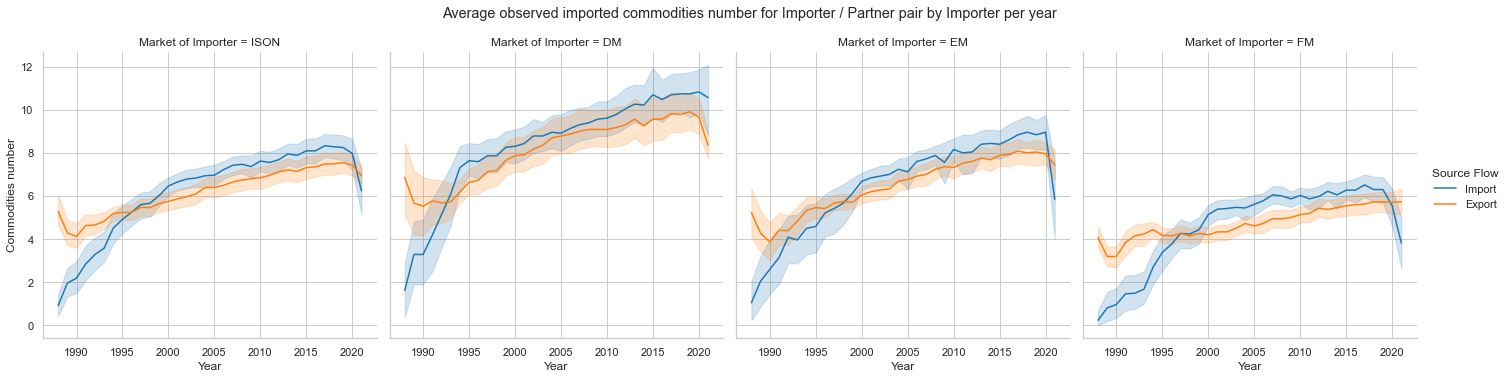

In [12]:
### EXPORT OBSERVATIONS INCORPORATION: OBSERVATIONS NUMBER BY FLOW

gc.collect()

dict_unique_mean = {}
dict_unique_mean['Import'] = df_import_aug['Import']\
                                          .groupby(['Date', 'Reporter', 'Partner', 'Market']).count()\
                                          .groupby(['Date', 'Reporter', 'Market']).mean()
dict_unique_mean['Export'] = df_import_aug['Export']\
                                          .groupby(['Date', 'Reporter', 'Partner', 'Market']).count()\
                                          .groupby(['Date', 'Reporter', 'Market']).mean()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source Flow']).round(0).astype(int)
ser_unique_mean.name = 'Commodities Number'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_region:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Commodities Number', col = 'Market of Importer', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average observed imported commodities number for Importer / Partner pair by Importer per year', y = 1.05)
fig_mean_unique.set_ylabels('Commodities number')
plt.show()

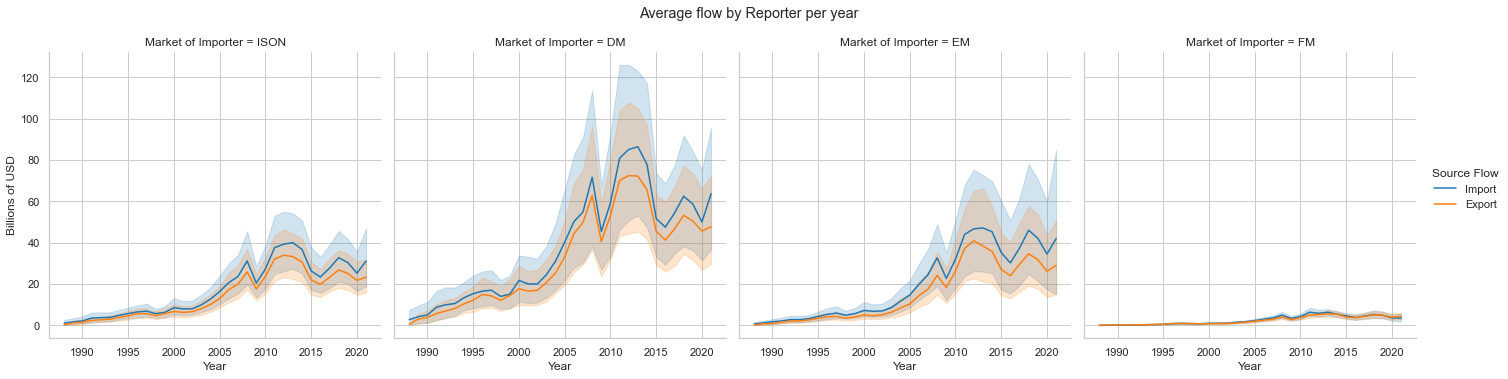

In [15]:
### EXPORT OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Import'] = df_import_aug['Import']\
                                          .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
dict_unique_sum['Export'] = df_import_aug['Export']\
                                          .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Import volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_sum.droplevel('Market').dropna()
for iter_region in list_region:
    dict_unique_source[iter_region] = ser_unique_sum.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Import volume', col = 'Market of Importer', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
plt.show()

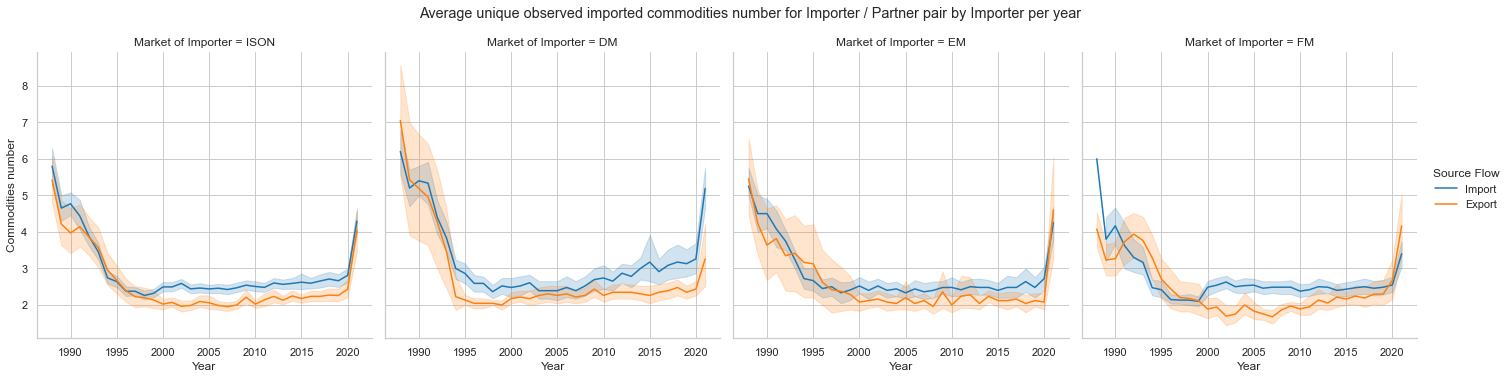

In [17]:
### IMPORT OBSERVATIONS INCORPORATION: UNIQUE OBSERVATIONS NUMBER

gc.collect()

dict_unique_mean = {}
dict_unique_mean['Import'] = df_import_aug.loc[df_import_aug['Import'].notna() & df_import_aug['Export'].isna(), 'Import']\
                                          .groupby(['Date', 'Reporter', 'Partner', 'Market']).count()\
                                          .groupby(['Date', 'Reporter', 'Market']).mean()
dict_unique_mean['Export'] = df_import_aug.loc[df_import_aug['Import'].isna() & df_import_aug['Export'].notna(), 'Export']\
                                          .groupby(['Date', 'Reporter', 'Partner', 'Market']).count()\
                                          .groupby(['Date', 'Reporter', 'Market']).mean()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source Flow']).round(0).astype(int)
ser_unique_mean.name = 'Commodities Number'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_region:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Commodities Number', col = 'Market of Importer', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average unique observed imported commodities number for Importer / Partner pair by Importer per year', y = 1.05)
fig_mean_unique.set_ylabels('Commodities number')
plt.show()

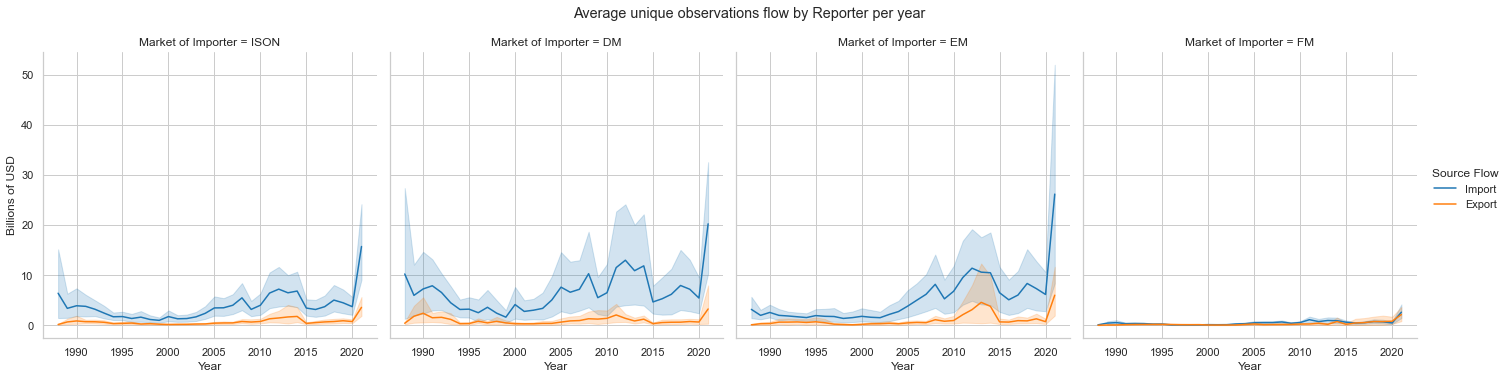

In [18]:
### EXPORT OBSERVATIONS INCORPORATION: UNIQUE OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Import'] = df_import_aug.loc[df_import_aug['Import'].notna() & df_import_aug['Export'].isna(), 'Import']\
                                          .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
dict_unique_sum['Export'] = df_import_aug.loc[df_import_aug['Import'].isna() & df_import_aug['Export'].notna(), 'Export']\
                                          .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Import volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_sum.droplevel('Market').dropna()
for iter_region in list_region:
    dict_unique_source[iter_region] = ser_unique_sum.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Import volume', col = 'Market of Importer', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average unique observations flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
plt.show()

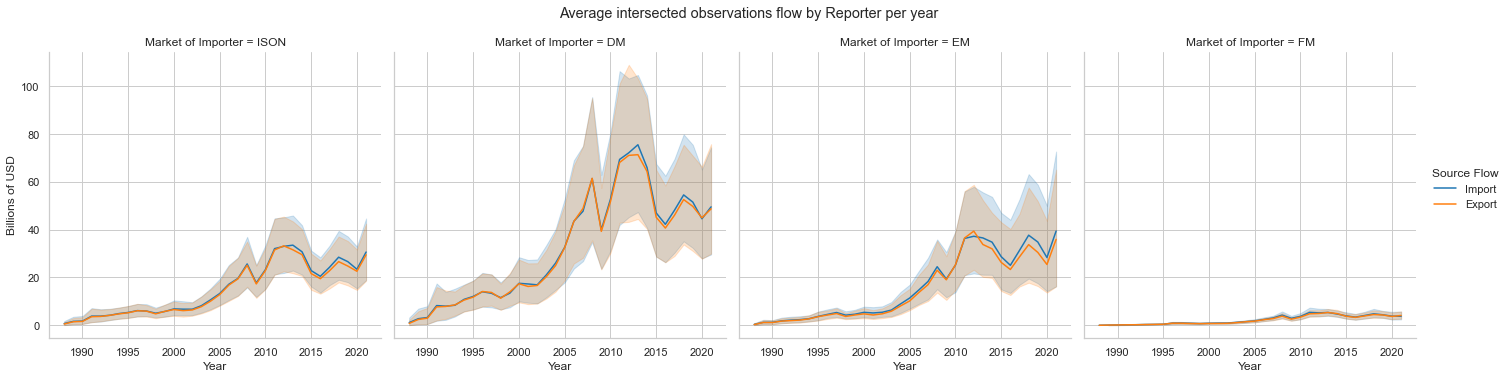

In [19]:
### EXPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_inter_sum = {}
dict_inter_sum['Import'] = df_import_aug.dropna()['Import']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
dict_inter_sum['Export'] = df_import_aug.dropna()['Export']\
                                          .groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
ser_inter_sum = pd.concat(dict_inter_sum, axis = 0, names = ['Source Flow']).round(2)
ser_inter_sum.name = 'Import volume'
del dict_inter_sum
gc.collect()
dict_inter_source = {}
dict_inter_source['ISON'] = ser_inter_sum.droplevel('Market').dropna()
for iter_region in list_region:
    dict_inter_source[iter_region] = ser_inter_sum.loc[All, All, All, iter_region].dropna()
### Average export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_inter_source, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Import volume', col = 'Market of Importer', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average intersected observations flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
plt.show()

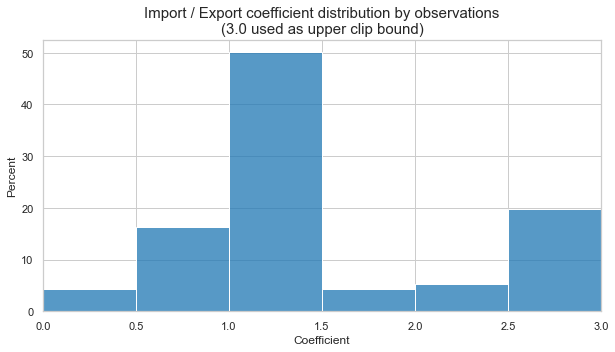

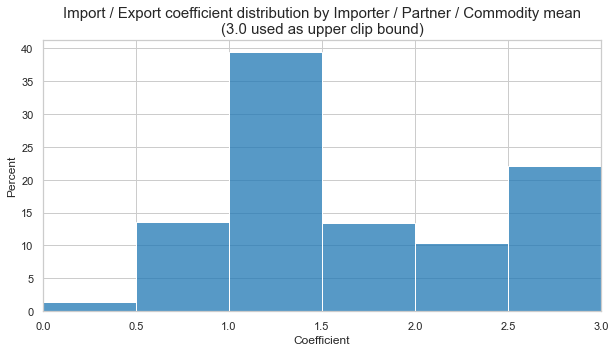

In [20]:
### EXPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS ANALYSIS

gc.collect()
### Observations with the largest absolute difference berween sources:
df_inter_aug = (df_import_aug.dropna() / 1000000000).round(2)
df_inter_aug['Difference'] = (df_inter_aug['Export'] - df_inter_aug['Import']).abs()
df_inter_aug.loc[df_inter_aug['Difference'].nlargest(20).index]
### Import / Export Coefficient distribution by observation:
flo_upper_bound = 3.0
df_inter_aug['Coefficient'] = (df_inter_aug['Import'] / df_inter_aug['Export']).round(2).clip(upper = flo_upper_bound)
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Import'] > 0.001, 'Coefficient'].reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by observations\n' + '(' + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()
### Import / Export Coefficient distribution by Exporter / Partner / Commodity averages:
flo_upper_bound = 3.0
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Import'] > 0.001].groupby(['Reporter', 'Partner', 'Commodity_Name'])['Coefficient'].mean().reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by Importer / Partner / Commodity mean\n' + '(' \
                        + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()

In [21]:
### CIF COEFFICIENTS CALCULATION

gc.collect()

### Bounds to filter bilateral Import to Export ratio before median calculation:
flo_lower_bound = 1.0
flo_upper_bound = 2.0

### Bilateral median calculation procedure:
def get_obs_median(df_comm):
    ### Export to Import ratio:
    ser_obs_coeff = df_comm['Import'] / df_comm['Export']
    ### Ratio filtering:
    ser_obs_coeff = ser_obs_coeff.loc[(ser_obs_coeff >= flo_lower_bound) & (ser_obs_coeff <= flo_upper_bound)]
    ### Filtered timeseries median as a result:
    return ser_obs_coeff.median()

### CIF calculation procedure for bilateral series by commodity:
def get_cif_coefficient(df_group):
    ### Bilateral median calulation:
    df_comm = df_group.droplevel(['Commodity_ID', 'Commodity_Name', 'Market'])
    ser_bilateral_median = df_comm.groupby(['Reporter', 'Partner']).apply(get_obs_median)
    ### General commodity median calculation:
    flo_median = ser_bilateral_median.median()
    print(df_group.iloc[0 : 1].index.to_list()[0][3 : 5], ':', flo_median)
    ### Filling missed bilateral values with general commodity median:
    ser_bilateral_median.fillna(flo_median, inplace = True)
    ### Results output:
    return ser_bilateral_median

### Calulation CIF coefficient for all commodities:
ser_cif_median = df_import_aug.groupby(['Commodity_ID', 'Commodity_Name']).apply(get_cif_coefficient)
ser_cif_median = ser_cif_median.reorder_levels(['Reporter', 'Partner', 'Commodity_ID', 'Commodity_Name'])
ser_cif_median.name = 'CIF_Coefficient'
#df_test = df_export_aug.loc[(All, All, All, All, ['Crude', 'Coffee'], All), All]
#ser_test = df_test.groupby(['Commodity_ID', 'Commodity_Name']).apply(get_cif_coefficient)

('0102', 'Cattle') : 1.2142886608192476
('0103', 'Swine') : 1.1687035705727296
('0901', 'Coffee') : 1.2385235407474207
('1001', 'Wheat') : 1.2224042032865317
('1005', 'Corn') : 1.241609631401006
('1201', 'Soya Beans') : 1.1991045569045233
('1208', 'Soya Meal') : 1.2834654461239041
('1507', 'Soya-Bean Oil') : 1.177427656788929
('1511', 'Palm Oil') : 1.2073034480592204
('1514', 'Rapeseed Oil') : 1.1611751784733664
('17', 'Sugar') : 1.2586157728886544
('18', 'Cocoa') : 1.2291073113003967
('2009', 'Orange Juice') : 1.2815969452399534
('2709', 'Crude') : 1.174085522951839
('2710', 'Petroleum Oils') : 1.273499612773534
('2711', 'Natural Gas') : 1.268456408552609
('52', 'Cotton') : 1.249059308367676
('7106', 'Silver') : 1.1816817232650756
('7108', 'Gold') : 1.1627002966128575
('7110', 'Platinum & Palladium') : 1.1701899858763496
('74', 'Copper') : 1.2493184768053718
('75', 'Nickel') : 1.278383132761454
('76', 'Aluminum') : 1.2446410467401225
('78', 'Lead') : 1.2022396402184676
('79', 'Zinc') 

In [ ]:
### TEMP

#ser_cif_median.loc[All, All, 'US', 'IL']

In [23]:
### DATA INCORPORATION:

### Adding CIF coefficients to dataset:
df_import_cif = df_import_aug.merge(ser_cif_median, left_index = True, right_index = True)
df_import_cif = df_import_cif.reorder_levels(['Date', 'Reporter', 'Partner', 'Commodity_ID', 'Commodity_Name', 'Market'])
### Export correction:
df_import_cif['Export_Corrected'] = df_import_cif['Export'] * df_import_cif['CIF_Coefficient']
### Combining Export & Import data:
df_import_cif['Import_Augmented'] = df_import_cif['Import'].combine_first(df_import_cif['Export_Corrected'])
df_import_cif.drop('CIF_Coefficient', axis = 1, inplace = True)

In [126]:
### TEMP

#df_export_cif.loc[(All, 'US', 'IL', All, 'Crude', All), All]

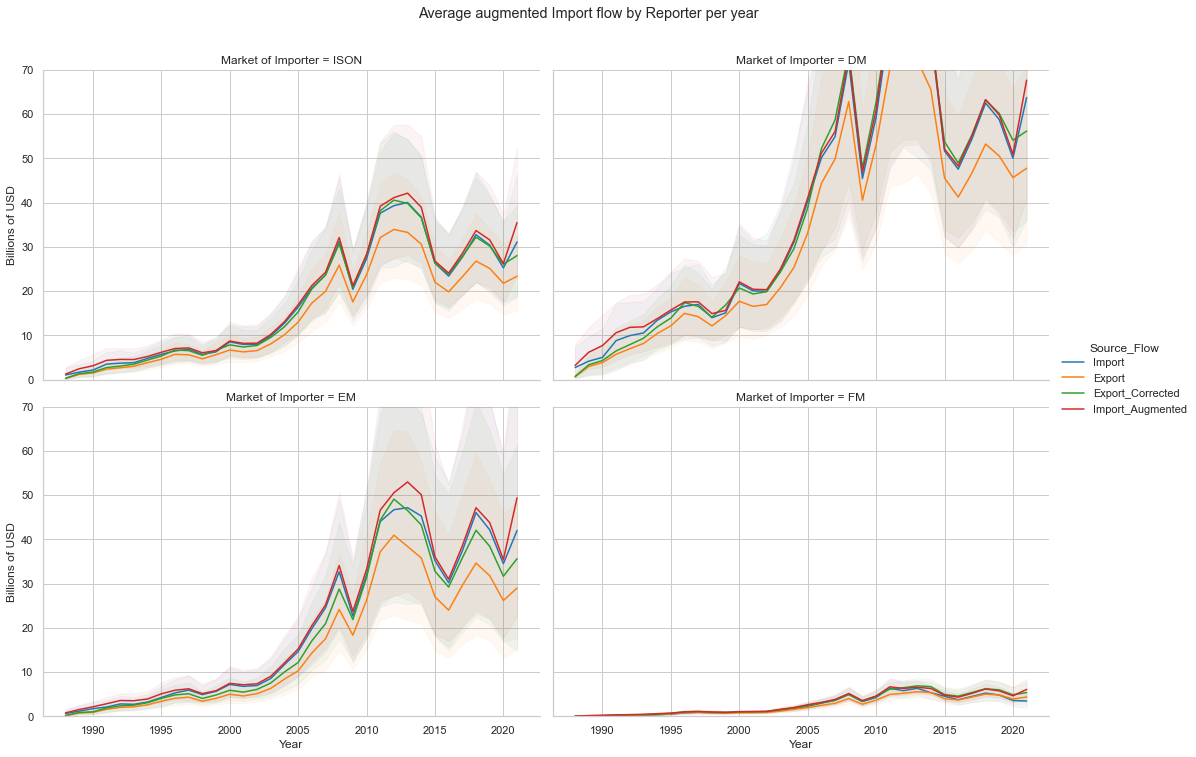

In [25]:
### IMPORT OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()
### Incorporation options:
df_options_sum = df_import_cif.groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
ser_options_sum = df_options_sum.reset_index().melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Source_Flow', value_name = 'Export_Volume')\
                                .set_index(['Date', 'Reporter', 'Market', 'Source_Flow']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['ISON'] = ser_options_sum.droplevel('Market')
for iter_region in list_region:
    dict_options_sum[iter_region] = ser_options_sum.loc[All, All, iter_region, All]
### Export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Importer']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Export_Volume', col = 'Market of Importer', col_wrap = 2, hue = 'Source_Flow', 
                              kind = 'line', aspect = 1.5, err_kws = {'alpha': 0.05})
fig_mean_unique.fig.suptitle('Average augmented Import flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 70))
plt.show()

In [26]:
### WORLD EXPORT DATA ADDING

### Total trading:
ser_comm_world = get_comtrade_data(str_flow = 'Import', str_flag = [0, 1], str_partner = 'World').droplevel(['Flow', 'Flag', 'Partner'])
### Adding empty cells to fill:
ser_comm_world = ser_comm_world.unstack(['Date', 'Reporter']).stack(['Date', 'Reporter'], dropna = False)\
                               .reorder_levels(['Date', 'Reporter', 'Commodity_ID', 'Commodity_Name'])
### Calculation of the sum of augmented Import for ISON universe:
ser_ison_sum = df_import_cif['Import_Augmented'].groupby(['Date', 'Reporter', 'Commodity_ID', 'Commodity_Name']).sum()
### Datasets combining:
ser_comm_world_aug = ser_comm_world.combine_first(ser_ison_sum)

(Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


In [28]:
### IMPORT OBSERVATIONS INCORPORATION: INCORPORATION PERFORMING

gc.collect()
### Bilateral export:
df_import_cif['Import_Augmented'].droplevel('Market')\
                            .to_hdf('Data_Files/Source_Files/commodities_import_bilateral.h5', key = 'import_augmented', mode = 'w', format = 'table', complevel = 9)
### World export:
ser_comm_world_aug.to_hdf('Data_Files/Source_Files/commodities_import_world.h5', key = 'import_augmented', mode = 'w', format = 'table', complevel = 9)

In [ ]:
### TEMP



In [ ]:
### TEMP

